
# **2 Training**

Scientific Computing Infrastructure


## 1. Preparations
### 1.1 Import required packages

In [1]:
import json
import os
import zipfile
import numpy as np
import geopandas as gpd
import sklearn
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import importlib

In [2]:
print(f"PyTorch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}")

from torch import nn

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124


### 1.2 Install segmentation model library

In [3]:
# !pip install segmentation-models-pytorch

In [4]:
import segmentation_models_pytorch as smp

### 1.3 Set device agnostic code

In [5]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU identified")

CUDA available: True
CUDA Version: 12.4
Number of GPUs: 1
GPU Name: Tesla V100-PCIE-32GB


In [6]:
# use gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1.4 Import data directories and configs-file

In [7]:
import os
print(os.path.abspath("configs"))

/home/sc.uni-leipzig.de/rf37uqip/MoSE/notebooks/configs


In [8]:
# path to repository folder
import sys
sys.path.append(os.path.abspath('/home/sc.uni-leipzig.de/rf37uqip/MoSE/'))

In [9]:
# import configs.py-file
from configs import configs_sc
importlib.reload(configs_sc) # reload changes

<module 'configs.configs_sc' from '/home/sc.uni-leipzig.de/rf37uqip/MoSE/configs/configs_sc.py'>

In [10]:
# input directories: patches and masks
patches_dir = configs_sc.DATA_DIR["patches"]
masks_dir = configs_sc.DATA_DIR["masks"]

# output directories: trained models
saved_model_dir = configs_sc.DATA_DIR["saved_models"]

# additional directories: class (labels and) codes
# labels_dir = configs_sc.DATA_DIR["labels"]
codes_dir = configs_sc.DATA_DIR["codes"]

### 1.5 Import and reload scripts

In [11]:
# import data_utils.py helper-functions script
from scripts import data_utils
importlib.reload(data_utils) # reload changes

# import model_utils.py helper-functions script
from scripts import model_utils
importlib.reload(model_utils) # reload changes

# import train_utils.py helper-functions script
from scripts import train_utils
importlib.reload(train_utils) # reload changes

# import evaluation_utils.py helper-functions script
from scripts import evaluation_utils
importlib.reload(evaluation_utils) # reload changes

# import visualization_utils.py helper function script
from scripts import visualization_utils
importlib.reload(visualization_utils) # reload changes

<module 'scripts.visualization_utils' from '/home/sc.uni-leipzig.de/rf37uqip/MoSE/scripts/visualization_utils.py'>

### 1.6 Check the data

a. Class codes dict

In [12]:
codes_path = os.path.join(codes_dir, "label_codes_ohe.json") # path

# open and load the JSON file
with open(codes_path, "r") as json_file:
    codes = json.load(json_file)

# reversed dictionary
reversed_codes = {v: k for k, v in codes.items()} # v = value, k = key
print(reversed_codes[4])
print(reversed_codes)

gravel bar
{1: 'woody debris', 2: 'rootstock', 3: 'sand/mud bar', 4: 'gravel bar', 0: 'background'}


b. Preprocessed patches

In [13]:
# list of all .npy-files (preprocessed patches)
################################################################################
patches_list = [f for f in os.listdir(patches_dir) if f.endswith('.npy')]
patches_list[0:3], len(patches_list)

(['A01_patch_142.npy', 'A01_patch_0.npy', 'A01_patch_144.npy'], 3836)

Shape of the patches: (3, 512, 512)
Datatype: float64
Type: <class 'numpy.ndarray'>
Mean: 0.17565934532858182
Minimum value: -2.1179039301310043
Maximum value: 2.6225708061002178


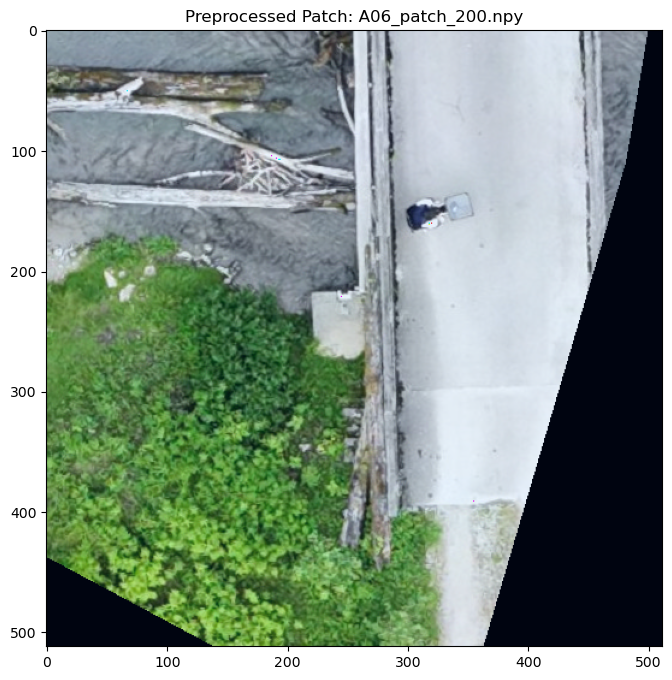

In [14]:
# Test one preprocessed patch
################################################################################

##################### choose single patch by section and id
SECTION = "A06" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 200 # -------------------->> ADJUSTABLE
#####################

# load the path to the patch
test_patch_name = f"{SECTION}_patch_{TEST_PATCH_ID}.npy"
test_patch_path = patches_dir + f"/" + test_patch_name

# load npz-file
test_patch = np.load(test_patch_path)

  # Show characteristics of the patch
print("Shape of the patches:", test_patch.shape)
print("Datatype:", test_patch.dtype)
print("Type:", type(test_patch))
print("Mean:", np.mean(test_patch))
print("Minimum value:", np.min(test_patch))
print("Maximum value:", np.max(test_patch))

# import the norm_plot_patch function for normalization and plotting of the test patch
visualization_utils.norm_plot_patch(test_patch, test_patch_name)

3. Masks

In [15]:
# list of all masks
################################################################################

masks_list = [f for f in os.listdir(masks_dir) if f.endswith('_mask.npy')]  # list of all masks
print(masks_list[0:3])
len(masks_list)

['A01_patch_180_mask.npy', 'A01_patch_0_mask.npy', 'A01_patch_138_mask.npy']


3836

In [16]:
# Test mask
################################################################################

##################### Choose single mask by section and id
SECTION = "A06" # -------------------->> ADJUSTABLE
TEST_MASK_ID = 200 # -------------------->> ADJUSTABLE
#####################

# Path to the chosen mask
test_mask_name = f"{SECTION}_patch_{TEST_MASK_ID}_mask.npy"
test_mask_path = masks_dir + f"/" + test_mask_name

# Load mask
test_mask = np.load(test_mask_path)

# Show properties of the mask
print("Shape of the mask:", test_mask.shape)
print("Datatype:", test_mask.dtype)
print("Type:", type(test_mask))
print("Minimum value:", np.min(test_mask))
print("Maximum value:", np.max(test_mask))
print("Unique values:", np.unique(test_mask), "\n") # binary mask



Shape of the mask: (5, 512, 512)
Datatype: uint8
Type: <class 'numpy.ndarray'>
Minimum value: 0
Maximum value: 1
Unique values: [0 1] 



Plot the mask

A06_patch_200_mask.npy


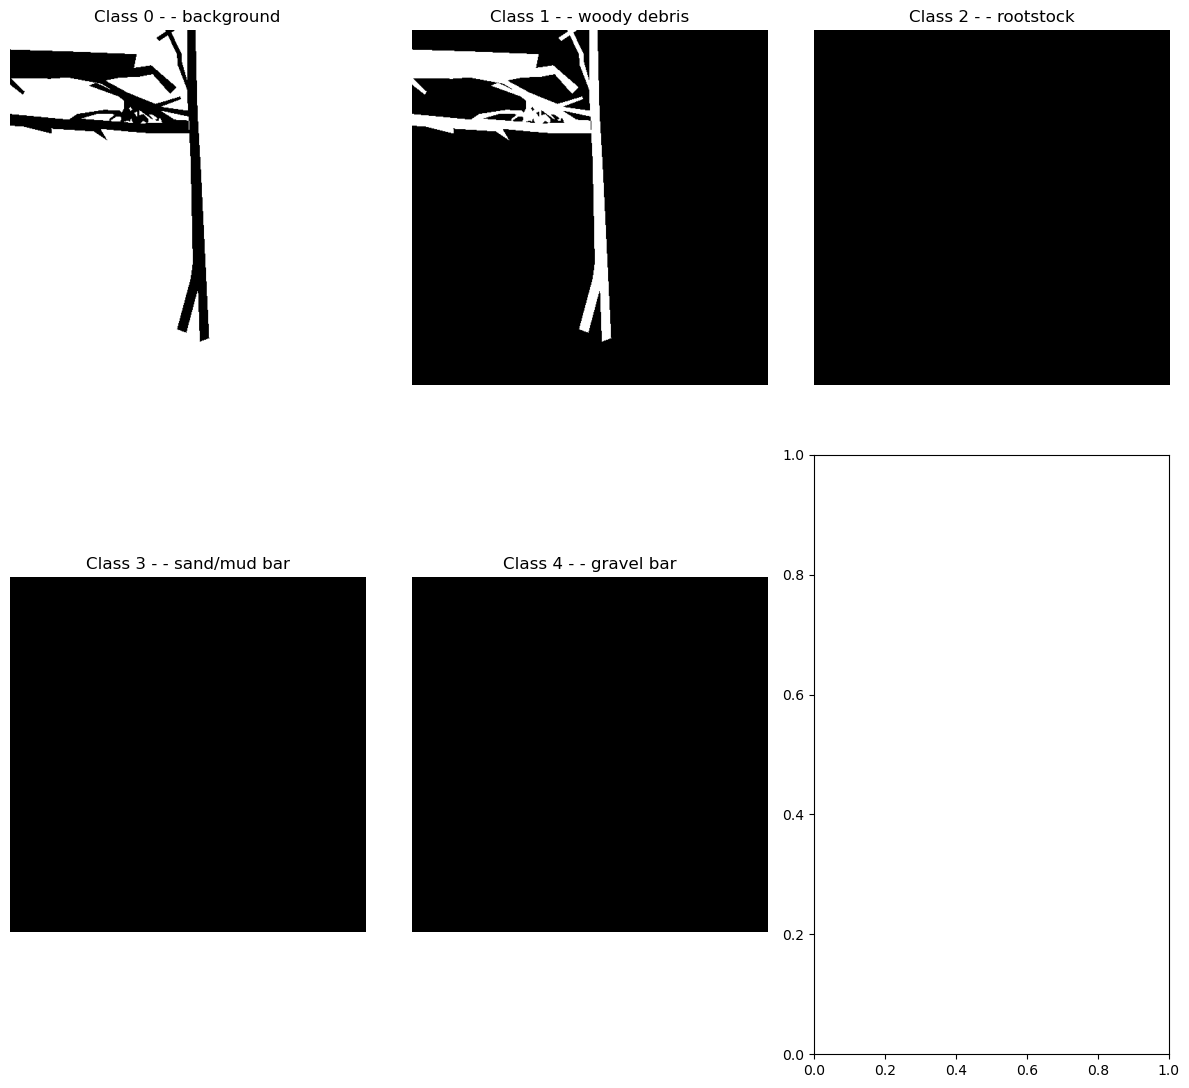

In [17]:
# ONE-HOT-ENCODED
print(test_mask_name)
fig, axes = plt.subplots(2, 3, figsize=(12, 12))  # 2x3 grid (for 5 classes)
axes = axes.flatten()  # easier to iterate through

for i in range(test_mask.shape[0]):  # iterate through the classes
  axes[i].imshow(test_mask[i], cmap="gray")
  axes[i].set_title(f"Class {i} - - {reversed_codes[i]}")
  axes[i].axis("off")

plt.tight_layout()
plt.show()

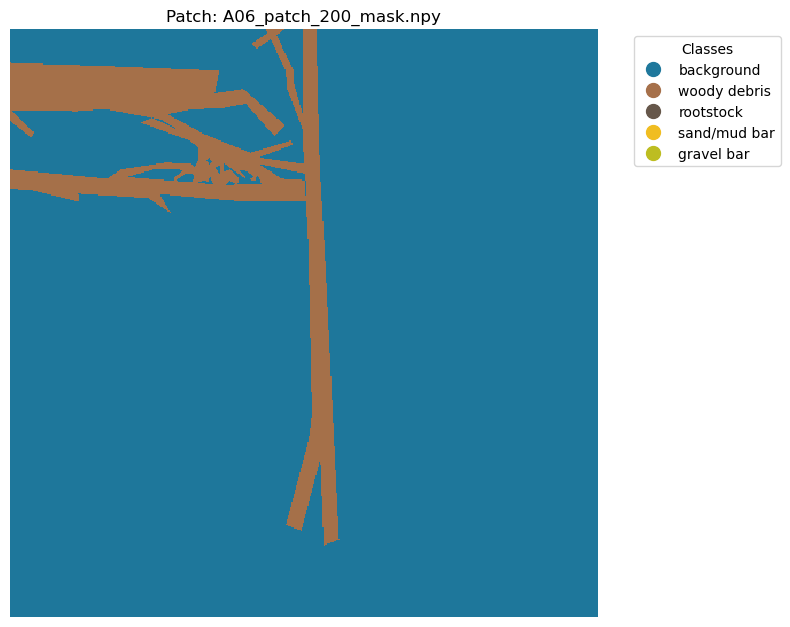

In [18]:
# alternative way of plotting the masks - not in one-hot-encoded, but in class-index-format
# CLASS-INDEX-FORMAT

# convert into class-index format
test_mask_idxformat = np.argmax(test_mask, axis=0)

visualization_utils.plot_mask_idxformat(test_mask_idxformat, test_mask_name, reversed_codes, configs_sc.HYPERPARAMETERS["custom_colors"])

## 2. Splitting data into train and test datasets

In [19]:
# extract section and patch_id from masks and patches (utils function)
print(data_utils.extract_section_and_id(masks_list[2]))
print(data_utils.extract_section_and_id(patches_list[175]))

('A01', '138')
('A01', '255')


In [20]:
# group patches by section
################################################################################

section_patches = {} # empty dictionary
for patch in patches_list: # iterate over all preprocessed patches
    section, patch_id = data_utils.extract_section_and_id(patch) # extract section and id
    section_patches.setdefault(section, []).append((patch)) # creates keys of sections with their patches inside

print(section_patches.keys())
# print(section_patches)

dict_keys(['A01', 'A02', 'A04', 'A06', 'A03', 'A05', 'A07', 'A08'])


In [21]:
# Separate patches in Training and Validation/Test datasets by sections
################################################################################

# empty lists for patches
train_data = []
test_data = []

for section, files in section_patches.items(): # iterates through the dictionary of sections
    if section in configs_sc.HYPERPARAMETERS["train_sections"]: # if the section is a training section
        train_data.extend(files) # if yes, the patches are added to the training data
    elif section in configs_sc.HYPERPARAMETERS["test_sections"]:
        test_data.extend(files)

print(f"Training Patches: {len(train_data)}")
print(f"Test Patches: {len(test_data)}")
print(f"Testdata-Ratio: {100*(len(test_data)/len(train_data))}")
print(f"Traindata-Ratio: {100 - 100*(len(test_data)/len(train_data))}")

Training Patches: 3077
Test Patches: 759
Testdata-Ratio: 24.666883327916803
Traindata-Ratio: 75.3331166720832


In [22]:
# Show random patch name in training data
print(train_data[8])

# test if this random patch has a corresponding mask
data_utils.has_mask(train_data[8], masks_dir)

A01_patch_146.npy


True

In [23]:
# Separate training and test patches 
################################################################################

train_data = [f for f in train_data if data_utils.has_mask(f, masks_dir)]
test_data = [f for f in test_data if data_utils.has_mask(f, masks_dir)]

print(f"Training data- Number of patches: {len(train_data)}")
print(f"Test data - Number of patches: {len(test_data)}")

Training data- Number of patches: 3077
Test data - Number of patches: 759


## 3. Data augmentation, Dataset and DataLoader

### 3.1 Data augmentation

In [24]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define training transformations with augmentation using Albumentations
train_transforms = A.Compose([
    
    # horizontal flip with a probability of 0.5
    A.HorizontalFlip(p=0.5),
    # vertical flip 
    A.VerticalFlip(p=0.5), 
    # randomly rotate the image by 90 degrees 
    A.RandomRotate90(p=0.5), 
    # random adjustments to brightness, contrast, saturation, and hue
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5), 
    # affine transformation:
    A.Affine(rotate=(-90, 90), translate_percent=(-0.1, 0.1), scale=(0.9, 1.1), p=0.5),
    # - rotate: randomly rotate within the range (-90, 90) degrees
    # - translate_percent: randomly translate by up to ±10% of image dimensions
    # - scale: randomly scale the image between 0.9 and 1.1 times its original size
    # normalize the image using ImageNet statistics
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    # covert to Tensors
    ToTensorV2() 
], additional_targets={'mask': 'mask'}) # ensures the same transformation is applied to the mask


# Define test transformations without augmentation (only normalization and conversion to tensor)
test_transforms = A.Compose([
    # normalize the image using ImageNet statistics
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
    # covert to Tensors
    ToTensorV2() 
], additional_targets={'mask': 'mask'}) # ensures the same transformation is applied to the mask

### 3.2 Dataset

In [25]:
# # with Data augmentation
# ################################
# # Apply Datasets and check properties
# ################################################################################

# # Train dataset
# train_dataset = data_utils.PatchDatasetCplx(train_data, patches_dir, masks_dir, transform = train_transforms)

# # check properties of the train dataset:
# print("Train dataset:\n")
# print("Type of dataset:", type(train_dataset))
# print("Number of patches:", len(train_dataset))
# print("Random patch:", train_dataset[0][0])
# print("Patch shape:", train_dataset[0][1].shape)
# print("Mask shape:", train_dataset[0][2].shape, "\n")

# # Test datasets
# test_dataset = data_utils.PatchDatasetCplx(test_data, patches_dir, masks_dir, transform = test_transforms) 

# # check properties of the test dataset:
# print("Test dataset:\n")
# print("Type of dataset:", type(test_dataset))
# print("Number of patches:", len(test_dataset))
# print("Random patch:", test_dataset[0][0])
# print("Patch shape:", test_dataset[0][1].shape)
# print("Mask shape:", test_dataset[0][2].shape, "\n")

In [26]:
# without Data augmentation
###############################
# Apply Datasets and check properties
################################################################################

# Train dataset
train_dataset = data_utils.PatchDatasetSimple(train_data, patches_dir, masks_dir)

# check properties of the train dataset:
print("Train dataset:\n")
print("Type of dataset:", type(train_dataset))
print("Number of patches:", len(train_dataset))
print("Random patch:", train_dataset[0][0])
print("Patch shape:", train_dataset[0][1].shape)
print("Mask shape:", train_dataset[0][2].shape, "\n")

# Simple Test dataset
test_dataset = data_utils.PatchDatasetSimple(test_data, patches_dir, masks_dir) 

# check properties of the test dataset:
print("Test dataset:\n")
print("Type of dataset:", type(test_dataset))
print("Number of patches:", len(test_dataset))
print("Random patch:", test_dataset[0][0])
print("Patch shape:", test_dataset[0][1].shape)
print("Mask shape:", test_dataset[0][2].shape, "\n")

Train dataset:

Type of dataset: <class 'scripts.data_utils.PatchDatasetSimple'>
Number of patches: 3077
Random patch: A01_patch_142.npy
Patch shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([2, 512, 512]) 

Test dataset:

Type of dataset: <class 'scripts.data_utils.PatchDatasetSimple'>
Number of patches: 759
Random patch: A04_patch_30.npy
Patch shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([2, 512, 512]) 



### 3.3 DataLoader

Right now the data is in the form of Pytorch Datasets (see above). The next step is to prepare it with a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) or simply `DataLoader`.

The `DataLoader`
- helps load data into the model.
- for training and for inference.
- **turns a large `Dataset` into a Python iterable** of smaller chunks. These smaller chunks are called **batches** or **mini-batches** and can be set by the `batch_size` parameter.

In [27]:
from torch.utils.data import DataLoader

BATCH_SIZE = configs_sc.HYPERPARAMETERS["batch_size"]

# Train DataLoader
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print("Dataloader:", train_loader)

# Test DataLoader
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
# test_loader_simple = DataLoader(test_dataset_simple, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Check dataloader
print(f"Training Batches: {len(train_loader)}", f"= up to {len(train_loader)*BATCH_SIZE} patches")
print(f"Test Batches: {len(test_loader)}", f"= up to {len(test_loader)*BATCH_SIZE} patches")

Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x15190dc011c0>
Training Batches: 385 = up to 3080 patches
Test Batches: 95 = up to 760 patches


### 3.4 Data exploration and class weights

In [28]:
# # Explore one batch of data in train_loader
# for batch_idx, (names, images, masks) in enumerate(train_loader):
#     print(f"Batch {batch_idx + 1}:", "\n------------\n------------")
#     print(f"Names - first patch name of the batch: {names[0]}", "\n------------")
#     print(f"Image type: {type(images)}")
#     print(f"Images shape: {images.shape}")  # Should be [batch_size, channels, height, width]
#     print(f"Image excerpt of the first patch: {images[0,:,:4,:4]}")
#     print(f"Images dtype: {images.dtype}", "\n------------")
#     print(f"Masks shape: {masks.shape}")    # Should be [batch_size, channels, height, width]
#     print(f"Mask excerpt of the mask of the fourth patch: {masks[0,:,:2,:2]}")
#     print(f"Masks dtype: {masks.dtype}")
#     break # break after first batch (batch 1)

In [29]:
# # TRAIN LOADER
# # Show pixel distribution per class in train_loader
# pixel_distribution_train = data_utils.pixel_distribution_dataloader(
#     data_loader=train_loader,
#     num_classes= configs_sc.HYPERPARAMETERS["num_classes"],
#     device=device
# )

# # Visualize results
# plt.bar(pixel_distribution_train.keys(), pixel_distribution_train.values())
# plt.xlabel("Class")
# plt.ylabel("Percentage of Pixels (%)")
# plt.title("Pixel Distribution Across Classes (Train Dataset)")
# plt.xticks()
# plt.show()

In [30]:
# # TEST LOADER
# # Show pixel distribution per class in test_loader
# pixel_distribution_test = data_utils.pixel_distribution_dataloader(
#     data_loader=test_loader,
#     num_classes= configs_sc.HYPERPARAMETERS["num_classes"],
#     device=device
# )

# # Visualize results
# plt.bar(pixel_distribution_test.keys(), pixel_distribution_test.values())
# plt.xlabel("Class")
# plt.ylabel("Percentage of Pixels (%)")
# plt.title("Pixel Distribution Across Classes (Test Dataset)")
# plt.xticks()
# plt.show()

In [31]:
# pixel_dist_train = torch.tensor(list(pixel_distribution_train.values()), dtype=torch.float32, device=device)
pixel_dist_train = torch.tensor([98.5564,  1.4437], dtype=torch.float32, device=device)
print("Pixel distribution in train dataset:", pixel_dist_train)

Pixel distribution in train dataset: tensor([98.5564,  1.4437], device='cuda:0')


In [32]:
# calculate the (inverse proportional) weights to outweigh the class imbalances
class_weights = 1/ (pixel_dist_train/100)
print("Class weights:", class_weights)

normalized_weights = class_weights / class_weights.sum()
print("Normalized weights:", normalized_weights)

Class weights: tensor([ 1.0146, 69.2665], device='cuda:0')
Normalized weights: tensor([0.0144, 0.9856], device='cuda:0')


To take into account the class imbalances in this dataset, we adjust the weight parameters in the CrossEntropyLoss function accordingly. Based on the pixel distribution, the weights can be set as follows:

| Class | Average pixel distribution (%) | Normalized Weight |
| ----- | ----- | ----- |
| 0 | 98.5564 | 0.0144 |
| 1 | 1.4437   | 0.9856 |


(
| 2 | 0.1185 | 0.5546 |
| 3 | 0.2076 | 0.3164 |
| 4 | 0.7930 | 0.0829 |
)

## 4. Segmentation model

U-Net is a fully convolution neural network for image semantic segmentation. Consist of encoder and decoder parts connected with skip connections. Encoder extract features of different spatial resolution (skip connections) which are used by decoder to define accurate segmentation mask. 

URL: https://smp.readthedocs.io/en/latest/models.html#unet

In [33]:
################################################################################
# model_0 = smp.Unet(   # -------------------->> ADJUSTABLE
#     encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (3 for RGB)
#     classes=configs_sc.HYPERPARAMETERS["num_classes"],       # model output channels (number of classes)
# )
################################################################################

In [34]:
model = model_utils.model_0.to(device)

In [35]:
# show model costruction
# model.to(device)

In [36]:
# show (hidden) layers of the model
# model.state_dict().keys()

In [37]:
next(model.parameters()).device

device(type='cuda', index=0)

### 4.1 Setup loss, optimizer and evaluation metrics

Setup loss function and optimizer

In [38]:
# Setup loss function
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss(weight = normalized_weights).to(device)

In [39]:
# Setup optimizer
# optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
# optimizer = torch.optim.Adam(model.parameters(), configs_sc.HYPERPARAMETERS["learning_rate"], betas=(0.9, 0.999))

# AdamW = Adam with weight decay
from torch.optim import AdamW

optimizer = AdamW(
    model.parameters(),
    lr=configs_sc.HYPERPARAMETERS["learning_rate"],  # learning rate
    weight_decay=1e-4  # regularisation
)

Evaluation metrics

In [40]:
accuracy_fn = evaluation_utils.oa_accuracy_fn

### 4.2 Training and test loop

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss per batch.
3. Loop through testing batches, perform testing steps, calculate the test loss per batch.

Learning rate: 1e-06
Number of epochs: 50


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------
Train Loss of [Batch 0/385]: 0.8261
Train Loss of [Batch 100/385]: 0.8823
Train Loss of [Batch 200/385]: 0.7944
Train Loss of [Batch 300/385]: 0.6982

Train loss: 0.78780 | Train accuracy: 72.32%
Train Class-wise Loss: tensor([0.9644, 0.5660], device='cuda:0')

Test loss: 0.68988 | Test accuracy: 71.16%
Test Class-wise Loss: tensor([1.0998, 0.3574], device='cuda:0')



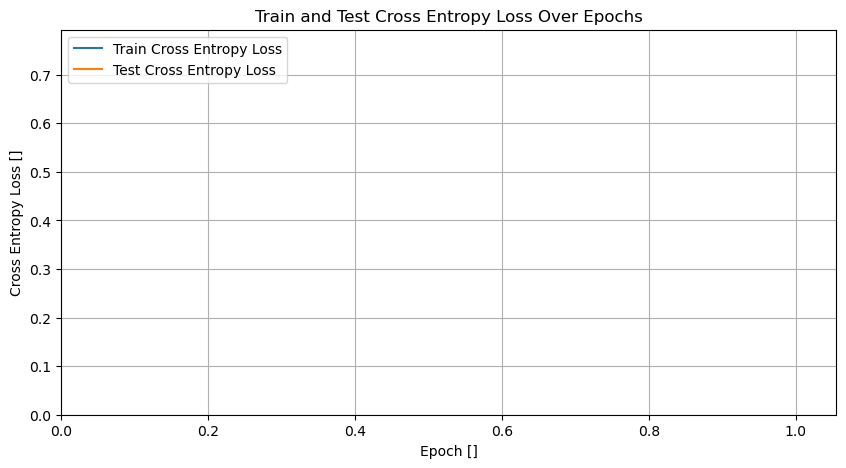

Epoch: 1
---------
Train Loss of [Batch 0/385]: 0.5882
Train Loss of [Batch 100/385]: 0.7487
Train Loss of [Batch 200/385]: 0.6005
Train Loss of [Batch 300/385]: 0.7471

Train loss: 0.67156 | Train accuracy: 75.94%
Train Class-wise Loss: tensor([0.9078, 0.3750], device='cuda:0')

Test loss: 0.62092 | Test accuracy: 73.45%
Test Class-wise Loss: tensor([1.1370, 0.2746], device='cuda:0')



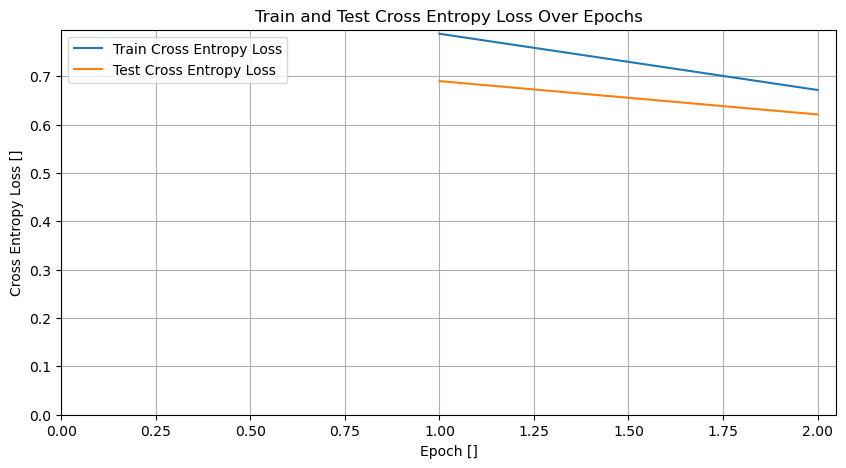

Epoch: 2
---------
Train Loss of [Batch 0/385]: 0.6062
Train Loss of [Batch 100/385]: 0.5507
Train Loss of [Batch 200/385]: 0.6984
Train Loss of [Batch 300/385]: 0.4934

Train loss: 0.60388 | Train accuracy: 79.55%
Train Class-wise Loss: tensor([0.8384, 0.3116], device='cuda:0')

Test loss: 0.56719 | Test accuracy: 77.54%
Test Class-wise Loss: tensor([1.0645, 0.2666], device='cuda:0')



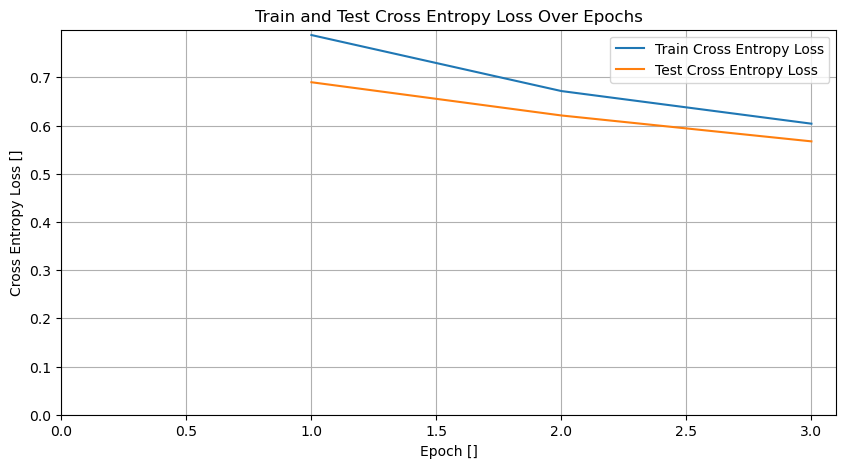

Epoch: 3
---------
Train Loss of [Batch 0/385]: 0.7623
Train Loss of [Batch 100/385]: 0.6557
Train Loss of [Batch 200/385]: 0.7123
Train Loss of [Batch 300/385]: 0.4880

Train loss: 0.56374 | Train accuracy: 82.15%
Train Class-wise Loss: tensor([0.7838, 0.2871], device='cuda:0')

Test loss: 0.54177 | Test accuracy: 78.42%
Test Class-wise Loss: tensor([1.0579, 0.2448], device='cuda:0')



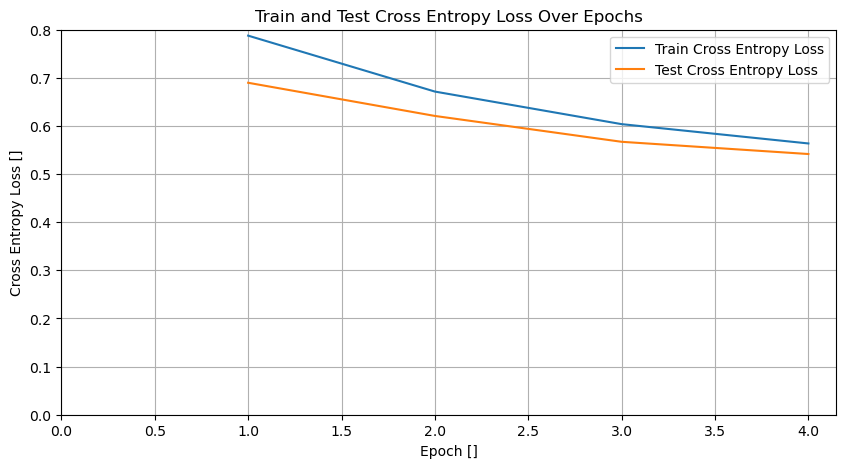

Epoch: 4
---------
Train Loss of [Batch 0/385]: 0.5765
Train Loss of [Batch 100/385]: 0.6627
Train Loss of [Batch 200/385]: 0.5042
Train Loss of [Batch 300/385]: 0.5879

Train loss: 0.52753 | Train accuracy: 83.82%
Train Class-wise Loss: tensor([0.7411, 0.2559], device='cuda:0')

Test loss: 0.51147 | Test accuracy: 80.08%
Test Class-wise Loss: tensor([0.9897, 0.2455], device='cuda:0')



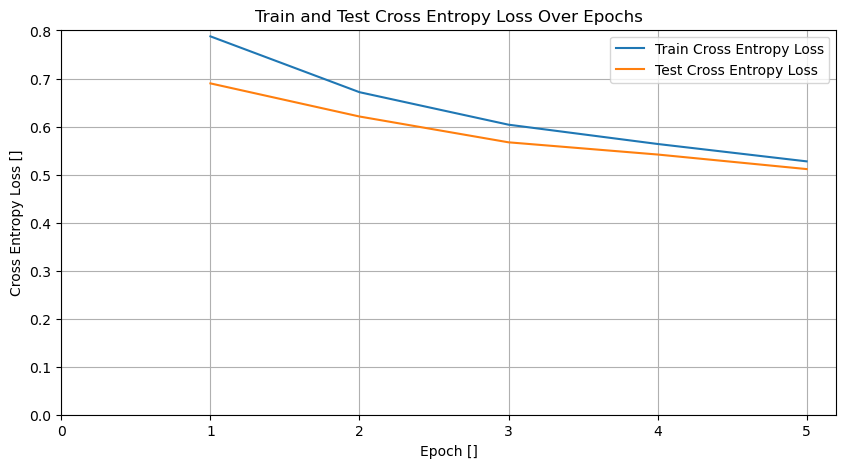

Epoch: 5
---------
Train Loss of [Batch 0/385]: 0.4805
Train Loss of [Batch 100/385]: 0.4376
Train Loss of [Batch 200/385]: 0.3622
Train Loss of [Batch 300/385]: 0.5115

Train loss: 0.50222 | Train accuracy: 84.68%
Train Class-wise Loss: tensor([0.7125, 0.2397], device='cuda:0')

Test loss: 0.50023 | Test accuracy: 80.49%
Test Class-wise Loss: tensor([1.0077, 0.2199], device='cuda:0')



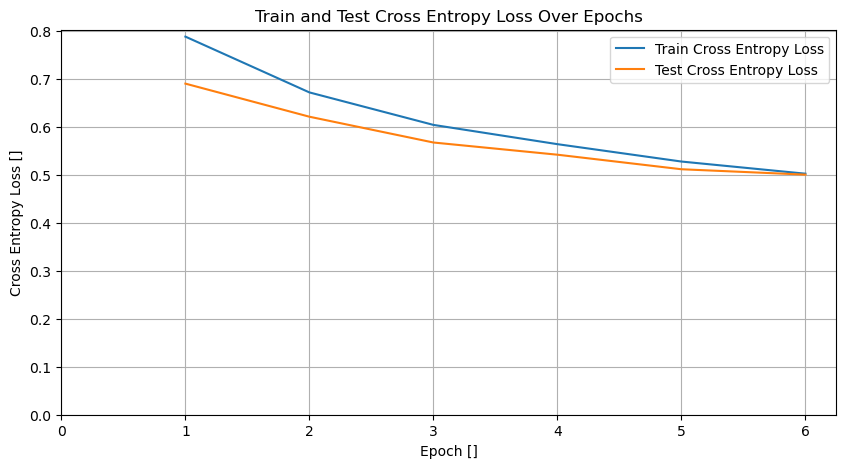

Epoch: 6
---------
Train Loss of [Batch 0/385]: 0.6079
Train Loss of [Batch 100/385]: 0.4049
Train Loss of [Batch 200/385]: 0.4006
Train Loss of [Batch 300/385]: 0.3813

Train loss: 0.48122 | Train accuracy: 85.67%
Train Class-wise Loss: tensor([0.6798, 0.2308], device='cuda:0')

Test loss: 0.46269 | Test accuracy: 82.12%
Test Class-wise Loss: tensor([0.8835, 0.2317], device='cuda:0')



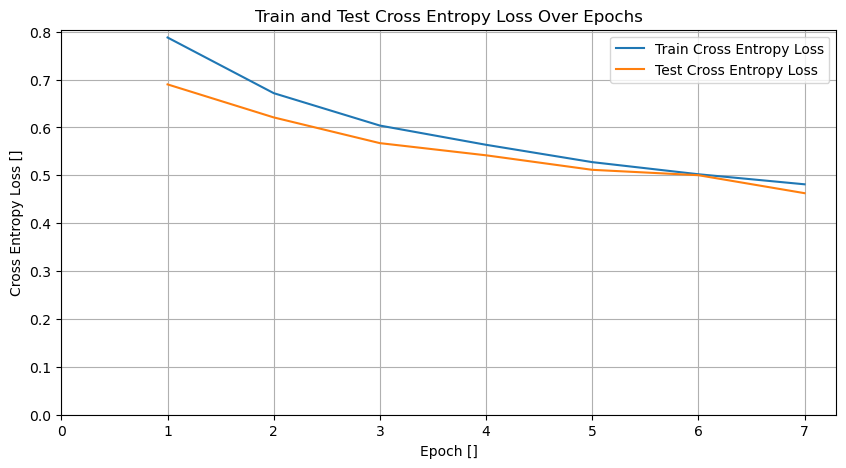

Epoch: 7
---------
Train Loss of [Batch 0/385]: 0.5394
Train Loss of [Batch 100/385]: 0.6683
Train Loss of [Batch 200/385]: 0.4690
Train Loss of [Batch 300/385]: 0.5256

Train loss: 0.45688 | Train accuracy: 86.61%
Train Class-wise Loss: tensor([0.6501, 0.2152], device='cuda:0')

Test loss: 0.43905 | Test accuracy: 83.79%
Test Class-wise Loss: tensor([0.8117, 0.2411], device='cuda:0')



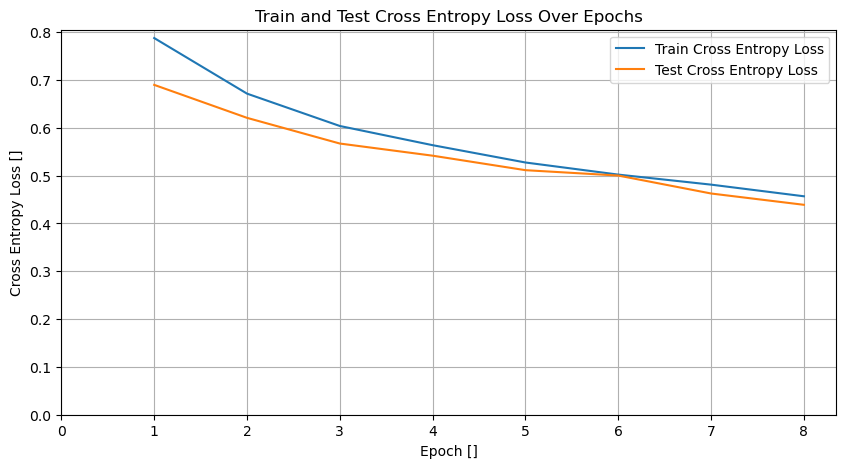

Epoch: 8
---------
Train Loss of [Batch 0/385]: 0.4164
Train Loss of [Batch 100/385]: 0.3450
Train Loss of [Batch 200/385]: 0.5724
Train Loss of [Batch 300/385]: 0.2973

Train loss: 0.43787 | Train accuracy: 87.31%
Train Class-wise Loss: tensor([0.6220, 0.2078], device='cuda:0')

Test loss: 0.43011 | Test accuracy: 83.37%
Test Class-wise Loss: tensor([0.8379, 0.2107], device='cuda:0')



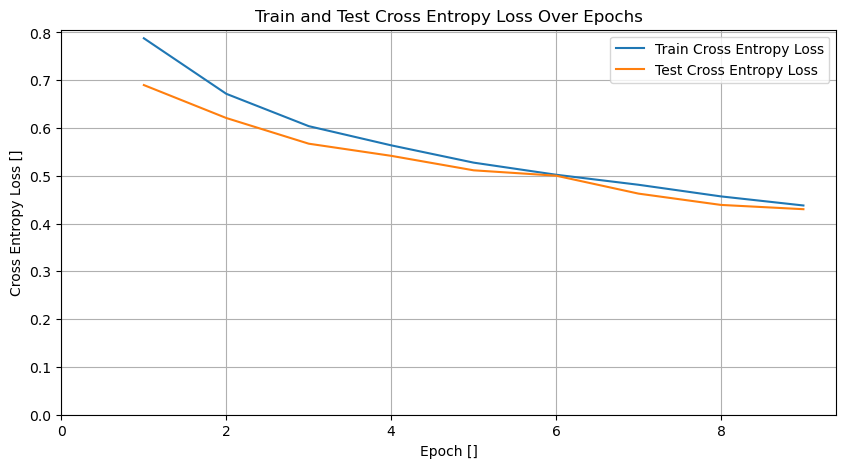

Epoch: 9
---------
Train Loss of [Batch 0/385]: 0.4045
Train Loss of [Batch 100/385]: 0.3911
Train Loss of [Batch 200/385]: 0.4244
Train Loss of [Batch 300/385]: 0.4978

Train loss: 0.41753 | Train accuracy: 88.15%
Train Class-wise Loss: tensor([0.5890, 0.1996], device='cuda:0')

Test loss: 0.41882 | Test accuracy: 83.73%
Test Class-wise Loss: tensor([0.8315, 0.2001], device='cuda:0')



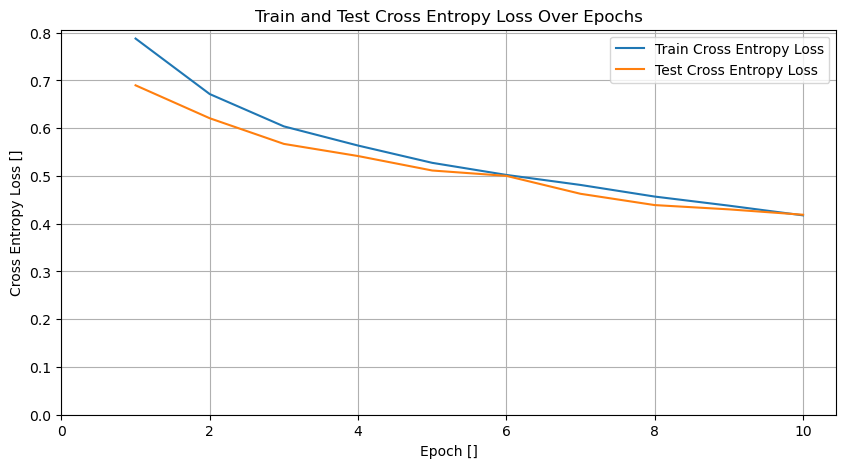

Epoch: 10
---------
Train Loss of [Batch 0/385]: 0.4662
Train Loss of [Batch 100/385]: 0.4295
Train Loss of [Batch 200/385]: 0.4866
Train Loss of [Batch 300/385]: 0.4509

Train loss: 0.39460 | Train accuracy: 88.73%
Train Class-wise Loss: tensor([0.5598, 0.1882], device='cuda:0')

Test loss: 0.40128 | Test accuracy: 84.52%
Test Class-wise Loss: tensor([0.7812, 0.2045], device='cuda:0')



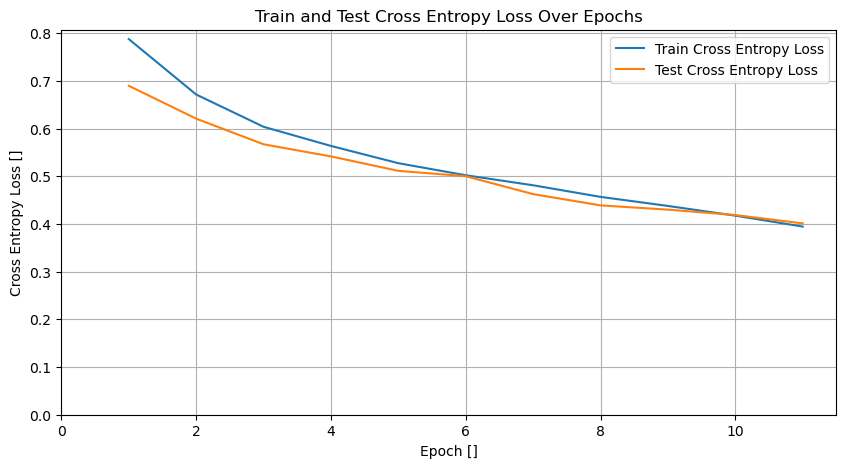

Epoch: 11
---------
Train Loss of [Batch 0/385]: 0.3578
Train Loss of [Batch 100/385]: 0.2930
Train Loss of [Batch 200/385]: 0.3738
Train Loss of [Batch 300/385]: 0.4098

Train loss: 0.38178 | Train accuracy: 89.27%
Train Class-wise Loss: tensor([0.5343, 0.1832], device='cuda:0')

Test loss: 0.36316 | Test accuracy: 86.98%
Test Class-wise Loss: tensor([0.6107, 0.2541], device='cuda:0')



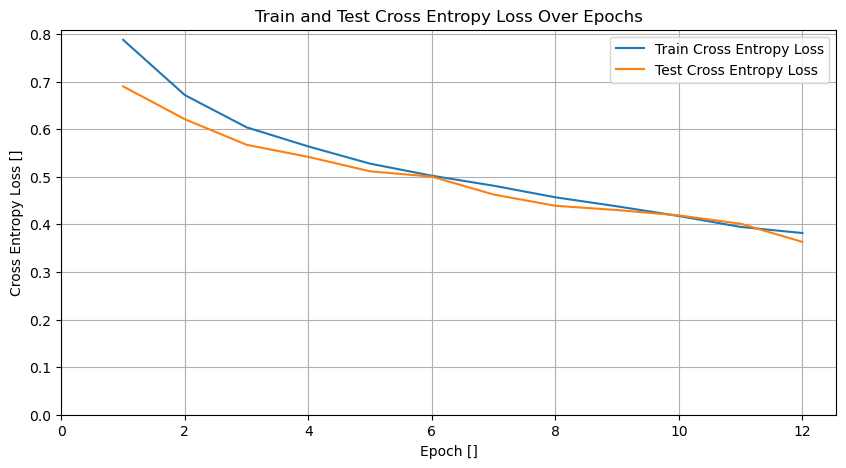

Epoch: 12
---------
Train Loss of [Batch 0/385]: 0.3570
Train Loss of [Batch 100/385]: 0.4767
Train Loss of [Batch 200/385]: 0.5275
Train Loss of [Batch 300/385]: 0.2980

Train loss: 0.36036 | Train accuracy: 89.45%
Train Class-wise Loss: tensor([0.5139, 0.1699], device='cuda:0')

Test loss: 0.36581 | Test accuracy: 84.49%
Test Class-wise Loss: tensor([0.6688, 0.2148], device='cuda:0')



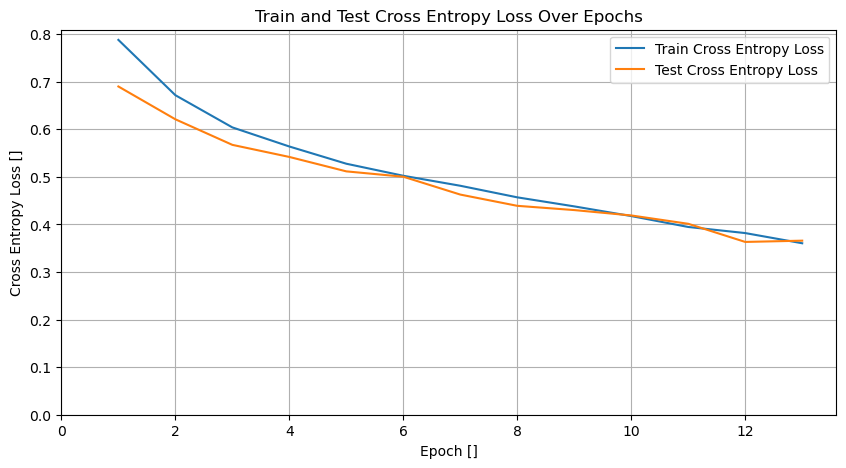

Epoch: 13
---------
Train Loss of [Batch 0/385]: 0.3458
Train Loss of [Batch 100/385]: 0.4693
Train Loss of [Batch 200/385]: 0.4654
Train Loss of [Batch 300/385]: 0.3076

Train loss: 0.34842 | Train accuracy: 89.79%
Train Class-wise Loss: tensor([0.4942, 0.1663], device='cuda:0')

Test loss: 0.34934 | Test accuracy: 85.87%
Test Class-wise Loss: tensor([0.6120, 0.2300], device='cuda:0')



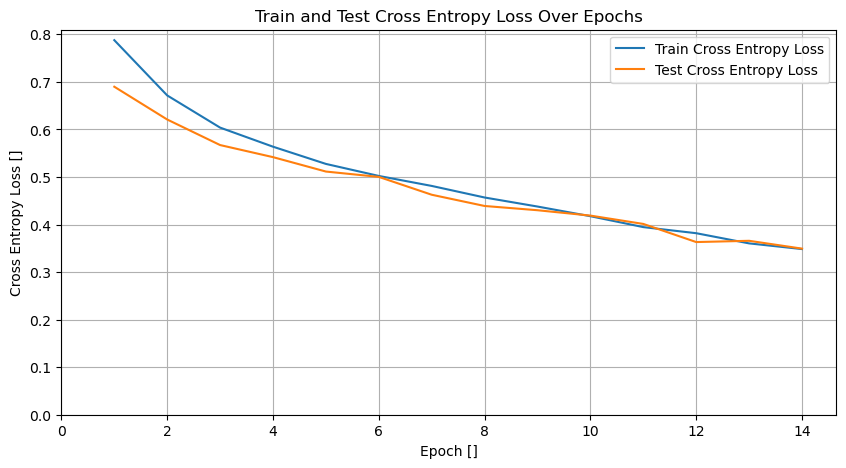

Epoch: 14
---------
Train Loss of [Batch 0/385]: 0.3527
Train Loss of [Batch 100/385]: 0.4419
Train Loss of [Batch 200/385]: 0.3476
Train Loss of [Batch 300/385]: 0.3694

Train loss: 0.33845 | Train accuracy: 90.10%
Train Class-wise Loss: tensor([0.4758, 0.1583], device='cuda:0')

Test loss: 0.34267 | Test accuracy: 86.01%
Test Class-wise Loss: tensor([0.5932, 0.2310], device='cuda:0')



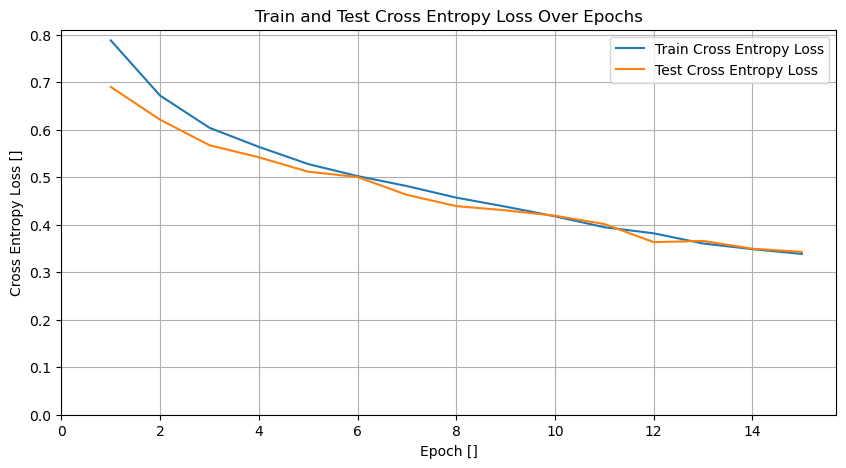

Epoch: 15
---------
Train Loss of [Batch 0/385]: 0.3400
Train Loss of [Batch 100/385]: 0.3913
Train Loss of [Batch 200/385]: 0.3217
Train Loss of [Batch 300/385]: 0.2828

Train loss: 0.32181 | Train accuracy: 90.46%
Train Class-wise Loss: tensor([0.4577, 0.1485], device='cuda:0')

Test loss: 0.33208 | Test accuracy: 86.80%
Test Class-wise Loss: tensor([0.5592, 0.2382], device='cuda:0')



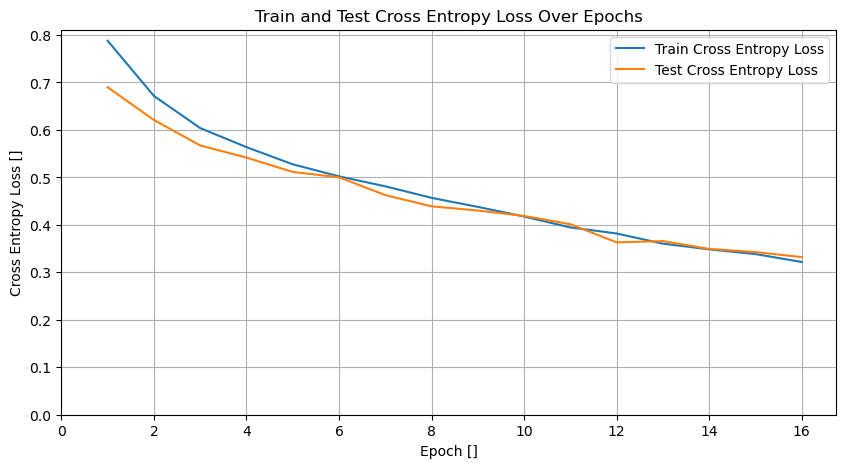

Epoch: 16
---------
Train Loss of [Batch 0/385]: 0.3416
Train Loss of [Batch 100/385]: 0.3805
Train Loss of [Batch 200/385]: 0.4706
Train Loss of [Batch 300/385]: 0.3444

Train loss: 0.31066 | Train accuracy: 90.76%
Train Class-wise Loss: tensor([0.4436, 0.1413], device='cuda:0')

Test loss: 0.32864 | Test accuracy: 86.07%
Test Class-wise Loss: tensor([0.5738, 0.2264], device='cuda:0')



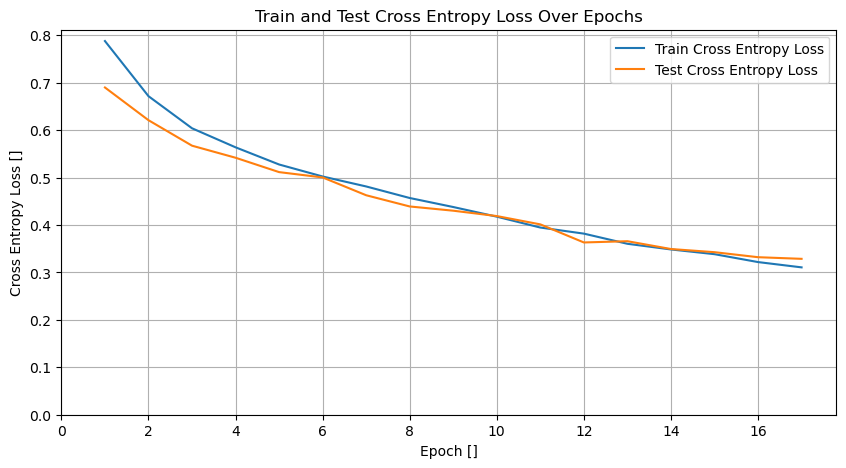

Epoch: 17
---------
Train Loss of [Batch 0/385]: 0.3396
Train Loss of [Batch 100/385]: 0.3052
Train Loss of [Batch 200/385]: 0.3184
Train Loss of [Batch 300/385]: 0.2967

Train loss: 0.30316 | Train accuracy: 91.18%
Train Class-wise Loss: tensor([0.4269, 0.1400], device='cuda:0')

Test loss: 0.32358 | Test accuracy: 86.38%
Test Class-wise Loss: tensor([0.5595, 0.2272], device='cuda:0')



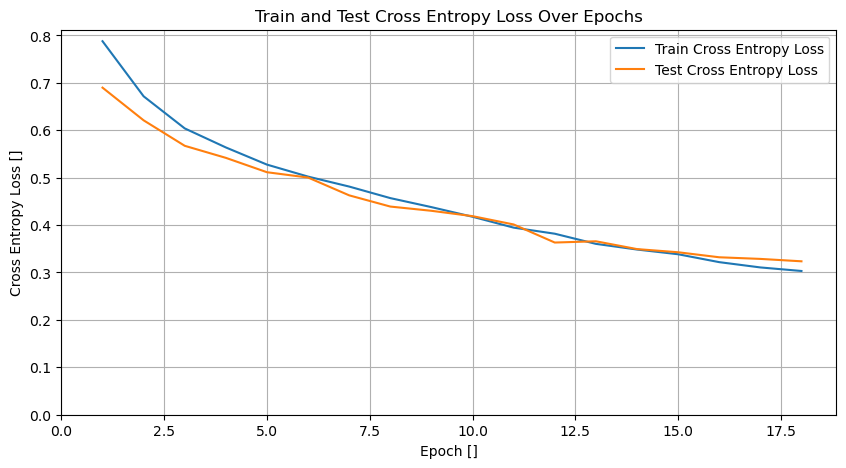

Epoch: 18
---------
Train Loss of [Batch 0/385]: 0.2364
Train Loss of [Batch 100/385]: 0.2782
Train Loss of [Batch 200/385]: 0.2332
Train Loss of [Batch 300/385]: 0.1990

Train loss: 0.29021 | Train accuracy: 91.54%
Train Class-wise Loss: tensor([0.4131, 0.1307], device='cuda:0')

Test loss: 0.31194 | Test accuracy: 89.10%
Test Class-wise Loss: tensor([0.4952, 0.2634], device='cuda:0')



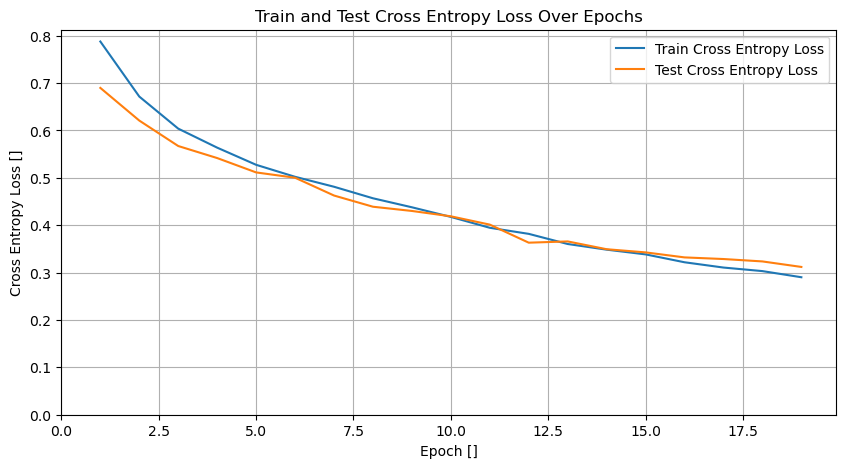

Epoch: 19
---------
Train Loss of [Batch 0/385]: 0.3686
Train Loss of [Batch 100/385]: 0.2640
Train Loss of [Batch 200/385]: 0.2581
Train Loss of [Batch 300/385]: 0.2944

Train loss: 0.28264 | Train accuracy: 91.88%
Train Class-wise Loss: tensor([0.3996, 0.1281], device='cuda:0')

Test loss: 0.30909 | Test accuracy: 88.66%
Test Class-wise Loss: tensor([0.4731, 0.2646], device='cuda:0')



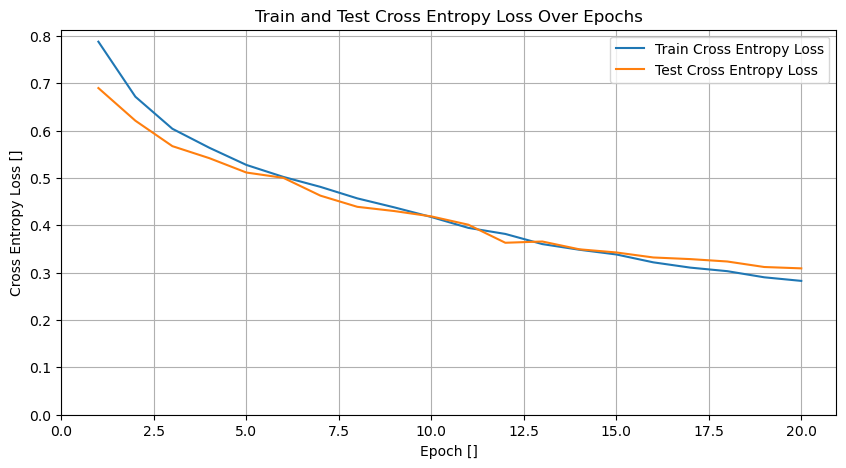

Epoch: 20
---------
Train Loss of [Batch 0/385]: 0.2291
Train Loss of [Batch 100/385]: 0.2365
Train Loss of [Batch 200/385]: 0.2896
Train Loss of [Batch 300/385]: 0.2554

Train loss: 0.26567 | Train accuracy: 92.25%
Train Class-wise Loss: tensor([0.3864, 0.1175], device='cuda:0')

Test loss: 0.30437 | Test accuracy: 88.19%
Test Class-wise Loss: tensor([0.4957, 0.2442], device='cuda:0')



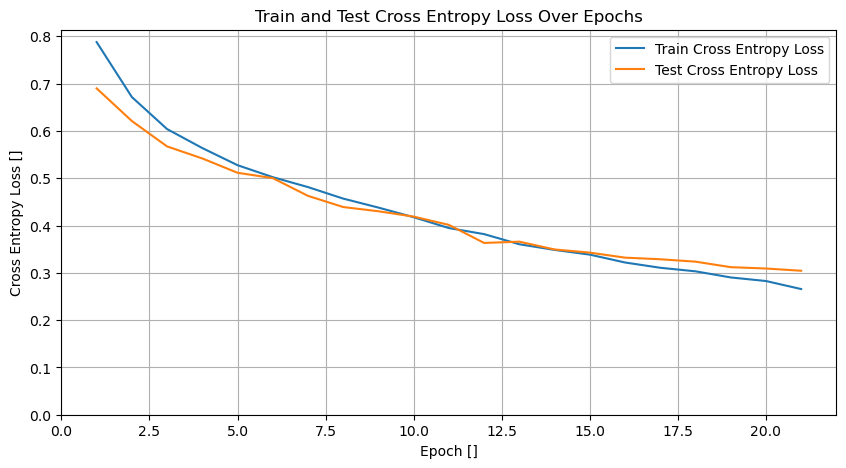

Epoch: 21
---------
Train Loss of [Batch 0/385]: 0.1885
Train Loss of [Batch 100/385]: 0.2369
Train Loss of [Batch 200/385]: 0.2443
Train Loss of [Batch 300/385]: 0.2848

Train loss: 0.26005 | Train accuracy: 92.64%
Train Class-wise Loss: tensor([0.3742, 0.1122], device='cuda:0')

Test loss: 0.30179 | Test accuracy: 90.20%
Test Class-wise Loss: tensor([0.4303, 0.2915], device='cuda:0')



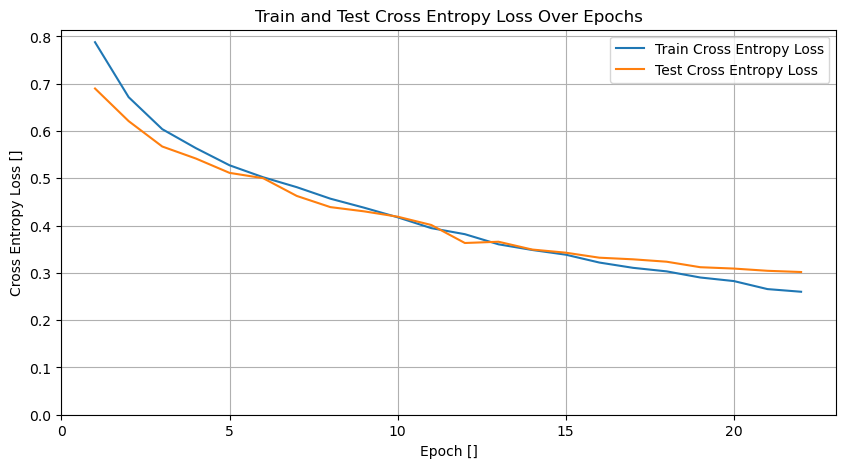

Epoch: 22
---------
Train Loss of [Batch 0/385]: 0.2463
Train Loss of [Batch 100/385]: 0.2808
Train Loss of [Batch 200/385]: 0.1994
Train Loss of [Batch 300/385]: 0.3350

Train loss: 0.25227 | Train accuracy: 92.98%
Train Class-wise Loss: tensor([0.3614, 0.1103], device='cuda:0')

Test loss: 0.29827 | Test accuracy: 90.09%
Test Class-wise Loss: tensor([0.4401, 0.2834], device='cuda:0')



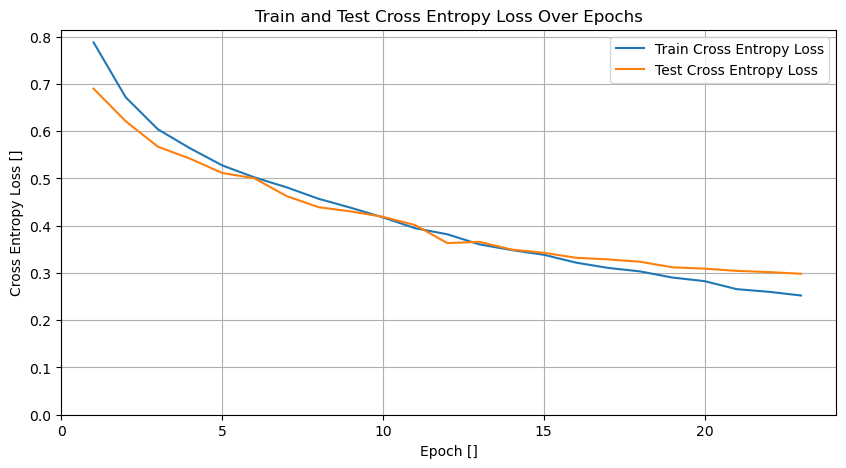

Epoch: 23
---------
Train Loss of [Batch 0/385]: 0.3411
Train Loss of [Batch 100/385]: 0.2408
Train Loss of [Batch 200/385]: 0.2484
Train Loss of [Batch 300/385]: 0.2177

Train loss: 0.24365 | Train accuracy: 93.32%
Train Class-wise Loss: tensor([0.3499, 0.1066], device='cuda:0')

Test loss: 0.29350 | Test accuracy: 89.45%
Test Class-wise Loss: tensor([0.4462, 0.2670], device='cuda:0')



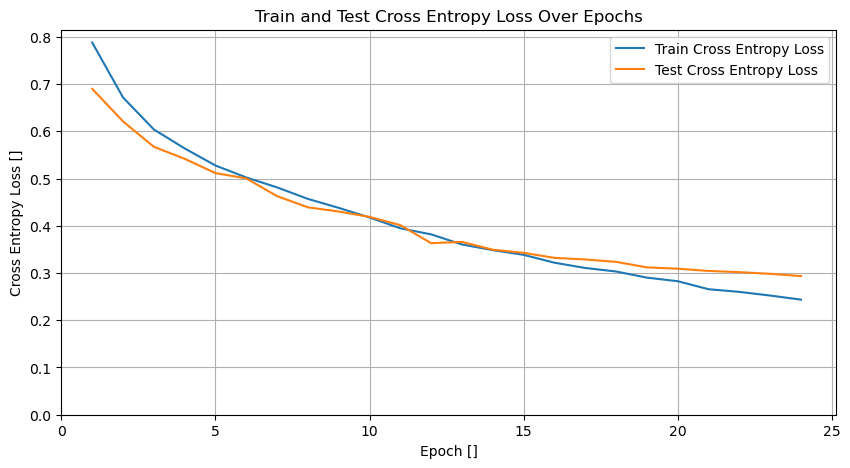

Epoch: 24
---------
Train Loss of [Batch 0/385]: 0.2751
Train Loss of [Batch 100/385]: 0.2239
Train Loss of [Batch 200/385]: 0.3557
Train Loss of [Batch 300/385]: 0.1674

Train loss: 0.23322 | Train accuracy: 93.64%
Train Class-wise Loss: tensor([0.3374, 0.1005], device='cuda:0')

Test loss: 0.29374 | Test accuracy: 90.15%
Test Class-wise Loss: tensor([0.4580, 0.2732], device='cuda:0')



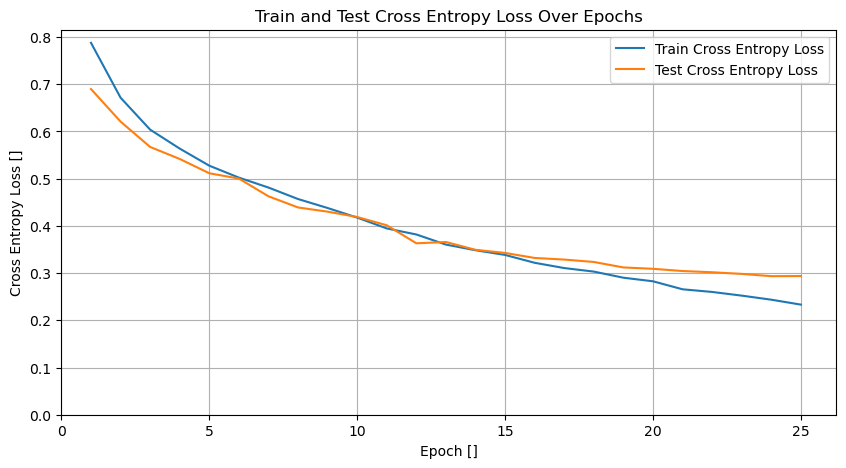

Epoch: 25
---------
Train Loss of [Batch 0/385]: 0.3251
Train Loss of [Batch 100/385]: 0.2924
Train Loss of [Batch 200/385]: 0.2133
Train Loss of [Batch 300/385]: 0.2070

Train loss: 0.22711 | Train accuracy: 93.95%
Train Class-wise Loss: tensor([0.3275, 0.0982], device='cuda:0')

Test loss: 0.29072 | Test accuracy: 89.99%
Test Class-wise Loss: tensor([0.4351, 0.2838], device='cuda:0')



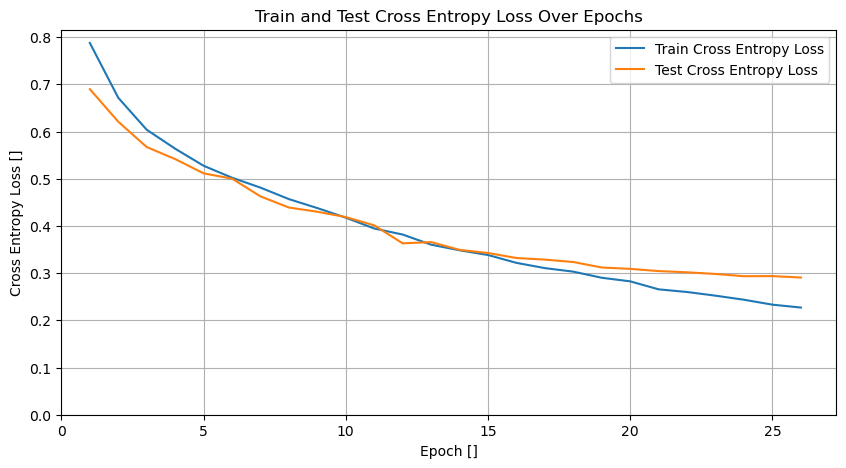

Epoch: 26
---------
Train Loss of [Batch 0/385]: 0.2811
Train Loss of [Batch 100/385]: 0.1802
Train Loss of [Batch 200/385]: 0.2182
Train Loss of [Batch 300/385]: 0.2732

Train loss: 0.22064 | Train accuracy: 94.24%
Train Class-wise Loss: tensor([0.3166, 0.0946], device='cuda:0')

Test loss: 0.28896 | Test accuracy: 91.36%
Test Class-wise Loss: tensor([0.3927, 0.3092], device='cuda:0')



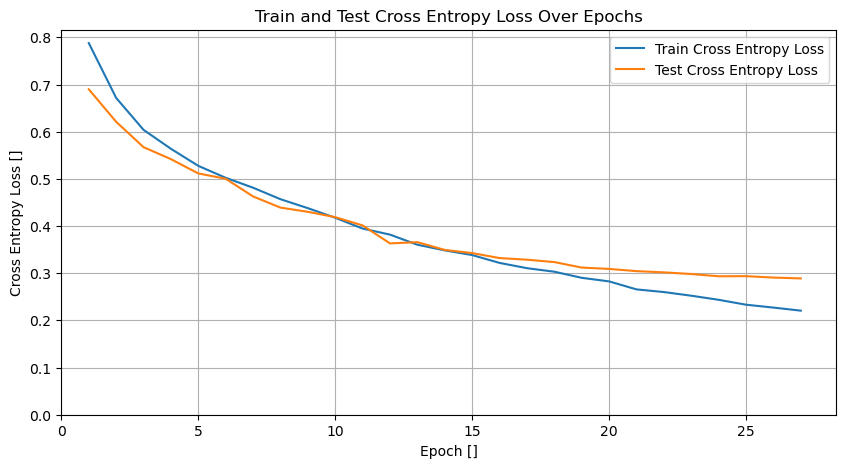

Epoch: 27
---------
Train Loss of [Batch 0/385]: 0.3106
Train Loss of [Batch 100/385]: 0.3311
Train Loss of [Batch 200/385]: 0.1901
Train Loss of [Batch 300/385]: 0.2604

Train loss: 0.21292 | Train accuracy: 94.50%
Train Class-wise Loss: tensor([0.3065, 0.0910], device='cuda:0')

Test loss: 0.28892 | Test accuracy: 90.84%
Test Class-wise Loss: tensor([0.4172, 0.3007], device='cuda:0')



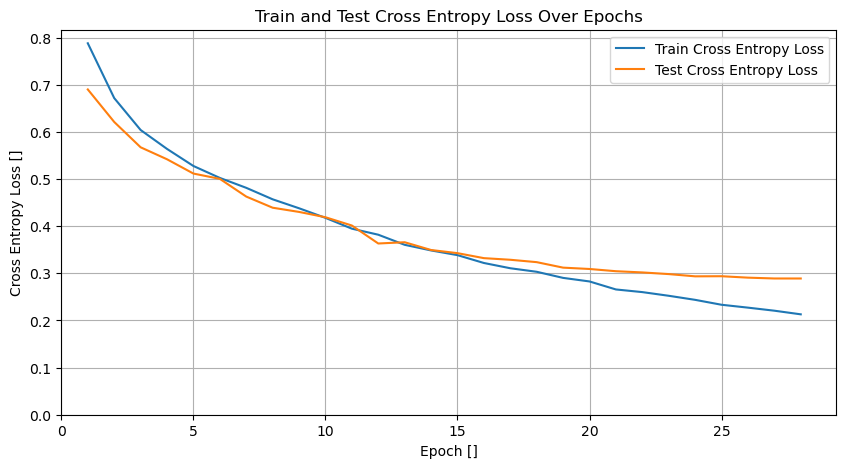

Epoch: 28
---------
Train Loss of [Batch 0/385]: 0.2064
Train Loss of [Batch 100/385]: 0.2213
Train Loss of [Batch 200/385]: 0.2489
Train Loss of [Batch 300/385]: 0.1621

Train loss: 0.20664 | Train accuracy: 94.75%
Train Class-wise Loss: tensor([0.2967, 0.0872], device='cuda:0')

Test loss: 0.28878 | Test accuracy: 92.40%
Test Class-wise Loss: tensor([0.3690, 0.3453], device='cuda:0')



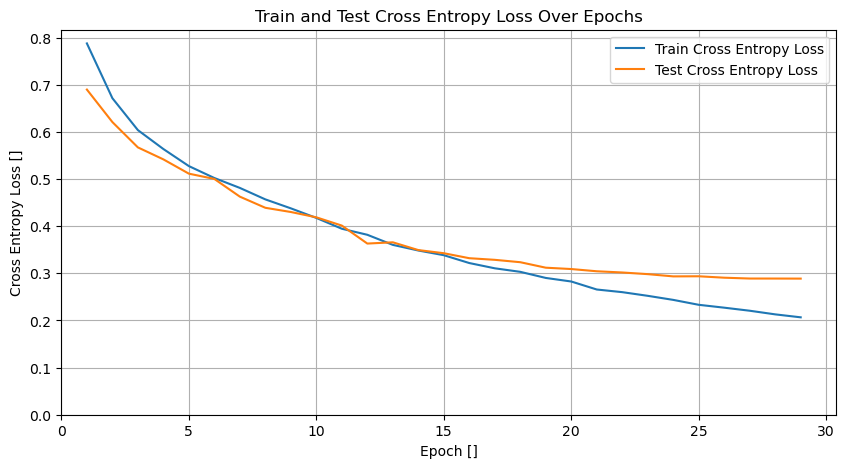

Epoch: 29
---------
Train Loss of [Batch 0/385]: 0.2259
Train Loss of [Batch 100/385]: 0.1617
Train Loss of [Batch 200/385]: 0.1737
Train Loss of [Batch 300/385]: 0.1575

Train loss: 0.20018 | Train accuracy: 95.04%
Train Class-wise Loss: tensor([0.2860, 0.0862], device='cuda:0')

Test loss: 0.29103 | Test accuracy: 92.45%
Test Class-wise Loss: tensor([0.3603, 0.3525], device='cuda:0')



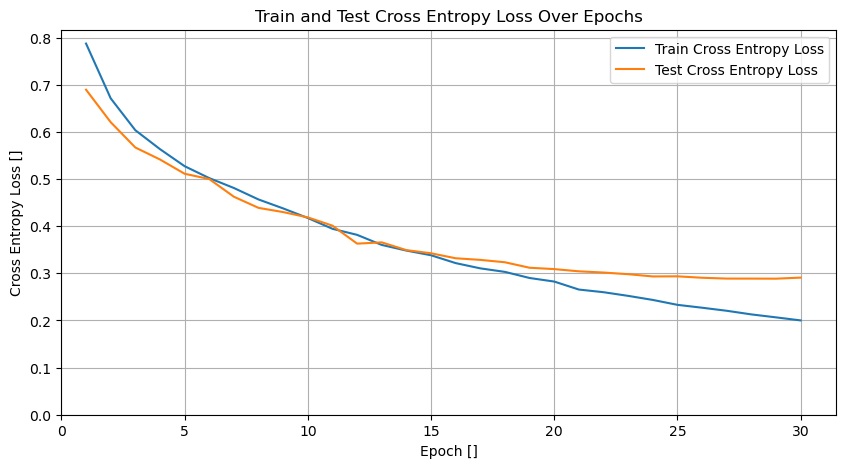

Epoch: 30
---------
Train Loss of [Batch 0/385]: 0.1741
Train Loss of [Batch 100/385]: 0.1589
Train Loss of [Batch 200/385]: 0.2061
Train Loss of [Batch 300/385]: 0.2025

Train loss: 0.19286 | Train accuracy: 95.16%
Train Class-wise Loss: tensor([0.2792, 0.0803], device='cuda:0')

Test loss: 0.29120 | Test accuracy: 92.82%
Test Class-wise Loss: tensor([0.3458, 0.3722], device='cuda:0')



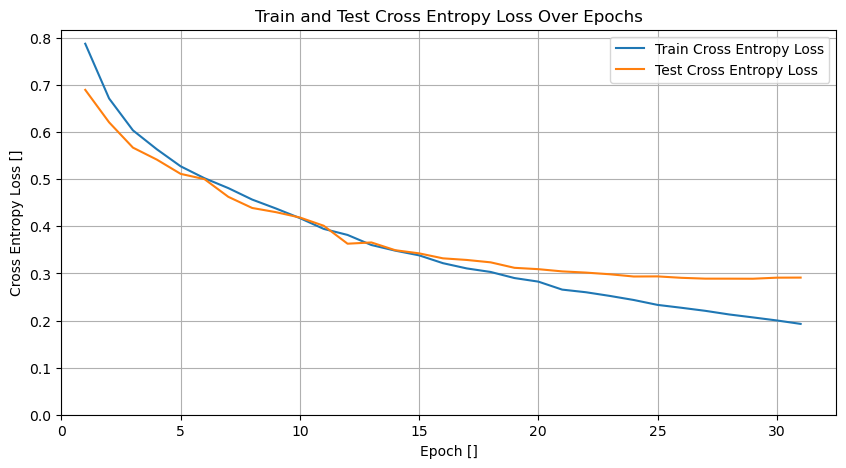

Epoch: 31
---------
Train Loss of [Batch 0/385]: 0.1530
Train Loss of [Batch 100/385]: 0.1598
Train Loss of [Batch 200/385]: 0.2278
Train Loss of [Batch 300/385]: 0.1846

Train loss: 0.18603 | Train accuracy: 95.38%
Train Class-wise Loss: tensor([0.2702, 0.0770], device='cuda:0')

Test loss: 0.28706 | Test accuracy: 92.24%
Test Class-wise Loss: tensor([0.3573, 0.3521], device='cuda:0')



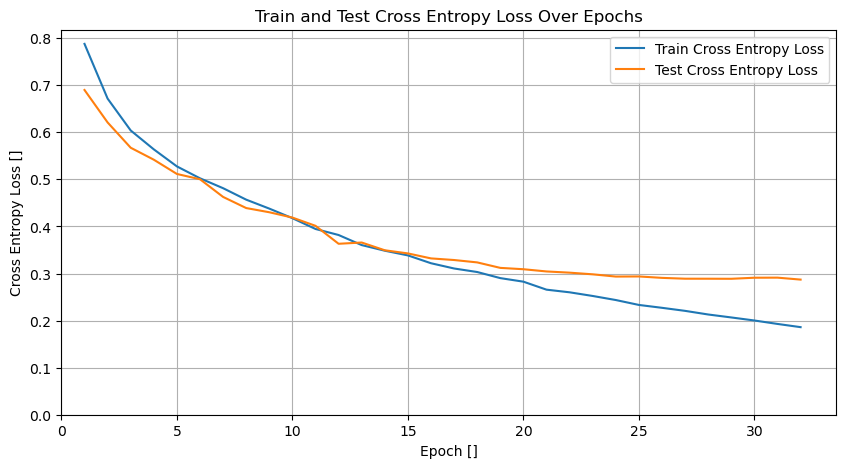

Epoch: 32
---------
Train Loss of [Batch 0/385]: 0.1604
Train Loss of [Batch 100/385]: 0.2035
Train Loss of [Batch 200/385]: 0.2158
Train Loss of [Batch 300/385]: 0.2756

Train loss: 0.18530 | Train accuracy: 95.60%
Train Class-wise Loss: tensor([0.2617, 0.0806], device='cuda:0')

Test loss: 0.28551 | Test accuracy: 93.01%
Test Class-wise Loss: tensor([0.3196, 0.3767], device='cuda:0')



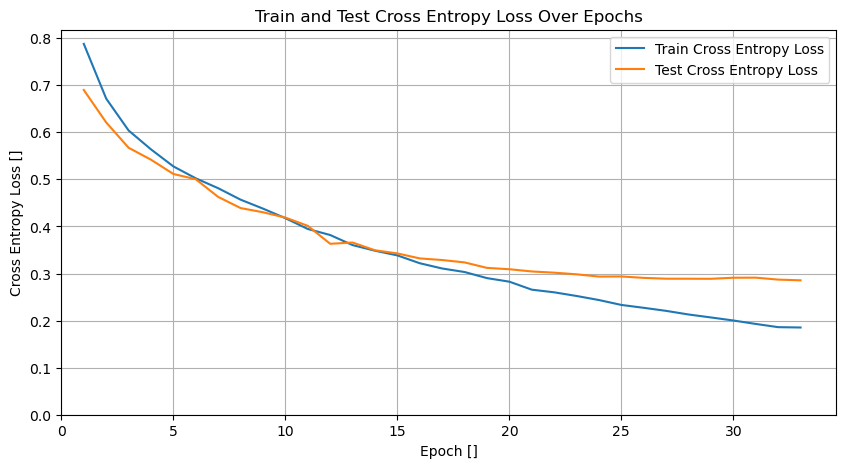

Epoch: 33
---------
Train Loss of [Batch 0/385]: 0.2280
Train Loss of [Batch 100/385]: 0.1651
Train Loss of [Batch 200/385]: 0.1767
Train Loss of [Batch 300/385]: 0.2103

Train loss: 0.17901 | Train accuracy: 95.72%
Train Class-wise Loss: tensor([0.2545, 0.0767], device='cuda:0')

Test loss: 0.28550 | Test accuracy: 92.93%
Test Class-wise Loss: tensor([0.3434, 0.3689], device='cuda:0')



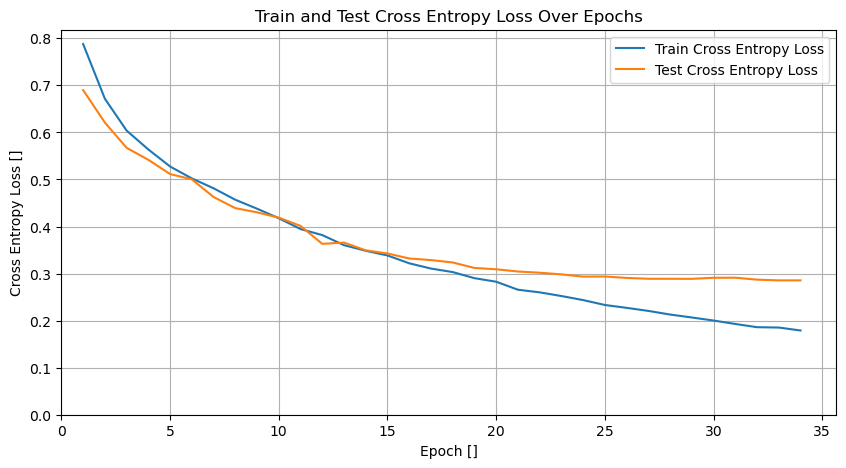

Epoch: 34
---------
Train Loss of [Batch 0/385]: 0.1635
Train Loss of [Batch 100/385]: 0.1611
Train Loss of [Batch 200/385]: 0.1615
Train Loss of [Batch 300/385]: 0.1941

Train loss: 0.17136 | Train accuracy: 95.86%
Train Class-wise Loss: tensor([0.2474, 0.0710], device='cuda:0')

Test loss: 0.28823 | Test accuracy: 93.12%
Test Class-wise Loss: tensor([0.3228, 0.3922], device='cuda:0')



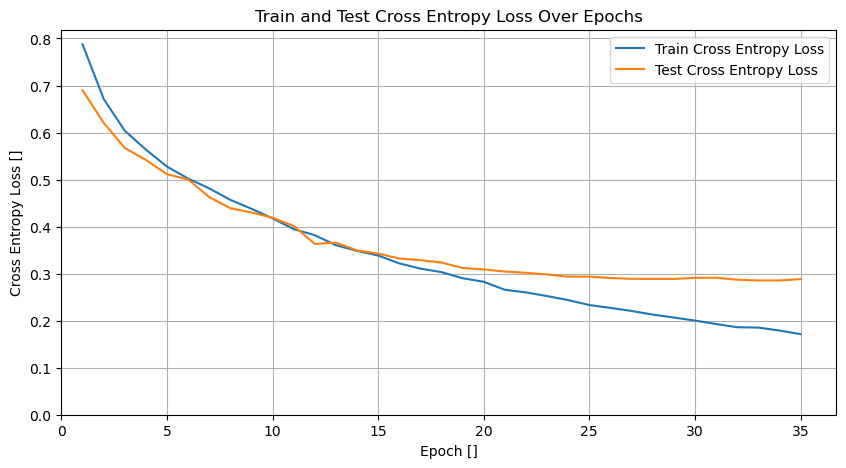

Epoch: 35
---------
Train Loss of [Batch 0/385]: 0.1712
Train Loss of [Batch 100/385]: 0.1315
Train Loss of [Batch 200/385]: 0.1726
Train Loss of [Batch 300/385]: 0.2100

Train loss: 0.16831 | Train accuracy: 96.05%
Train Class-wise Loss: tensor([0.2387, 0.0752], device='cuda:0')

Test loss: 0.29486 | Test accuracy: 93.95%
Test Class-wise Loss: tensor([0.3043, 0.4297], device='cuda:0')



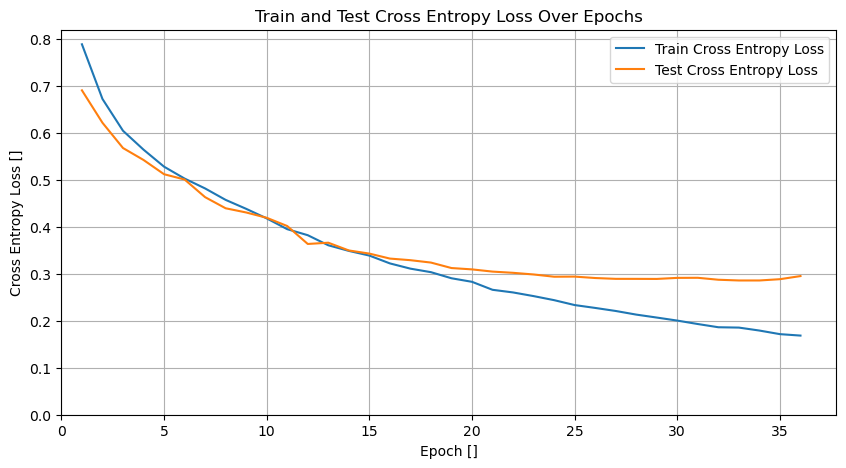

Epoch: 36
---------
Train Loss of [Batch 0/385]: 0.1509
Train Loss of [Batch 100/385]: 0.1663
Train Loss of [Batch 200/385]: 0.1446
Train Loss of [Batch 300/385]: 0.1621

Train loss: 0.16537 | Train accuracy: 96.12%
Train Class-wise Loss: tensor([0.2337, 0.0719], device='cuda:0')

Test loss: 0.28397 | Test accuracy: 93.26%
Test Class-wise Loss: tensor([0.3403, 0.3755], device='cuda:0')



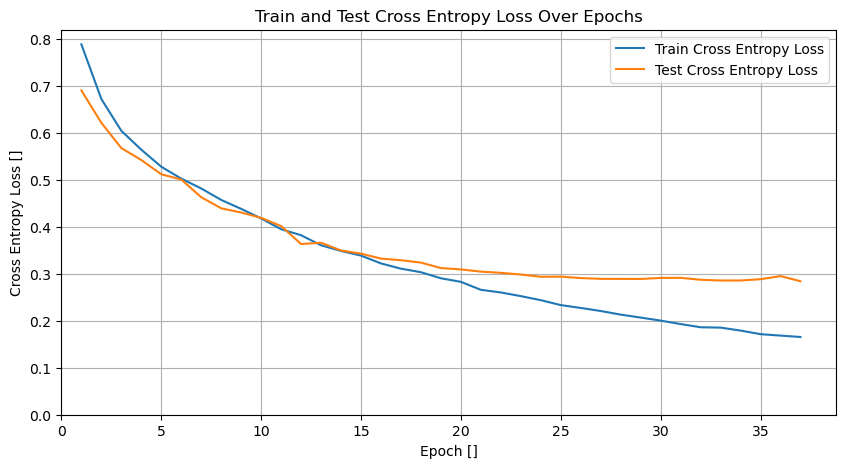

Epoch: 37
---------
Train Loss of [Batch 0/385]: 0.1390
Train Loss of [Batch 100/385]: 0.1922
Train Loss of [Batch 200/385]: 0.1284
Train Loss of [Batch 300/385]: 0.1797

Train loss: 0.16041 | Train accuracy: 96.24%
Train Class-wise Loss: tensor([0.2262, 0.0700], device='cuda:0')

Test loss: 0.30609 | Test accuracy: 94.55%
Test Class-wise Loss: tensor([0.2637, 0.4843], device='cuda:0')



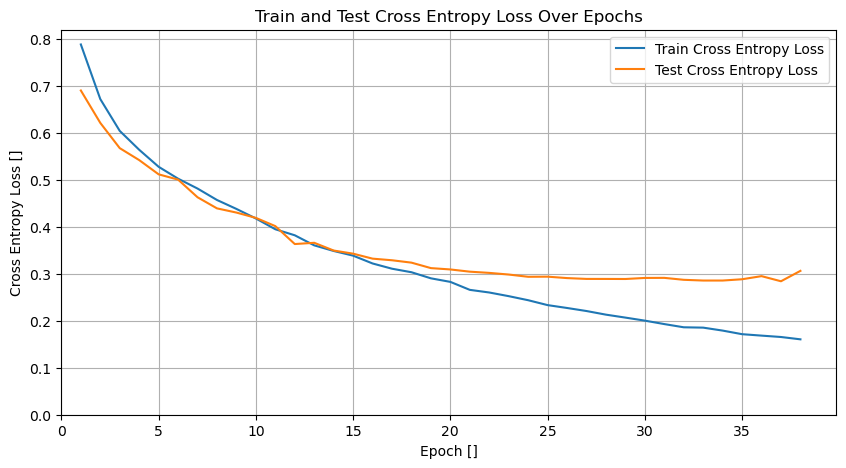

Epoch: 38
---------
Train Loss of [Batch 0/385]: 0.1560
Train Loss of [Batch 100/385]: 0.1343
Train Loss of [Batch 200/385]: 0.1695
Train Loss of [Batch 300/385]: 0.1834

Train loss: 0.15424 | Train accuracy: 96.34%
Train Class-wise Loss: tensor([0.2205, 0.0683], device='cuda:0')

Test loss: 0.29857 | Test accuracy: 93.87%
Test Class-wise Loss: tensor([0.2847, 0.4522], device='cuda:0')



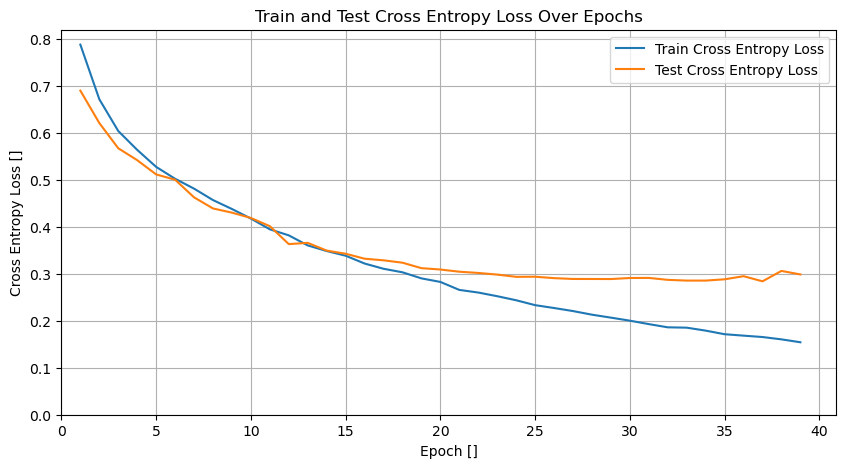

Epoch: 39
---------
Train Loss of [Batch 0/385]: 0.1545
Train Loss of [Batch 100/385]: 0.0996
Train Loss of [Batch 200/385]: 0.1159
Train Loss of [Batch 300/385]: 0.1709

Train loss: 0.15219 | Train accuracy: 96.35%
Train Class-wise Loss: tensor([0.2169, 0.0656], device='cuda:0')

Test loss: 0.28762 | Test accuracy: 93.29%
Test Class-wise Loss: tensor([0.3387, 0.3887], device='cuda:0')



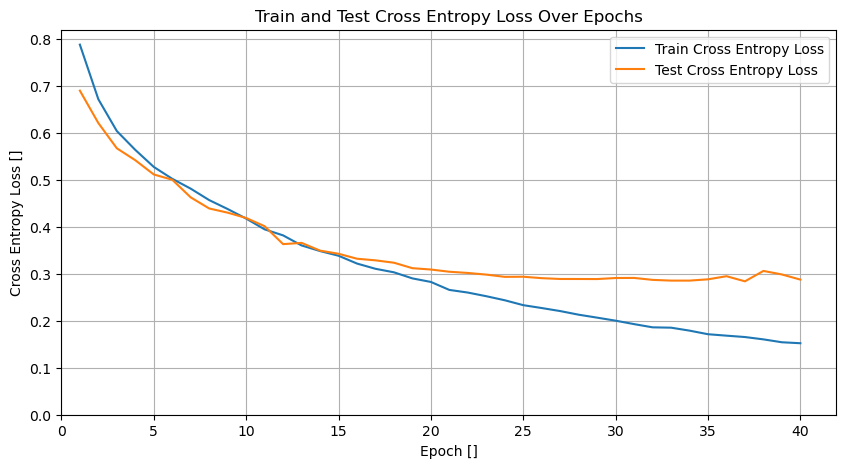

Epoch: 40
---------
Train Loss of [Batch 0/385]: 0.1011
Train Loss of [Batch 100/385]: 0.1539
Train Loss of [Batch 200/385]: 0.1576
Train Loss of [Batch 300/385]: 0.1167

Train loss: 0.14760 | Train accuracy: 96.55%
Train Class-wise Loss: tensor([0.2082, 0.0669], device='cuda:0')

Test loss: 0.29964 | Test accuracy: 94.14%
Test Class-wise Loss: tensor([0.2700, 0.4666], device='cuda:0')



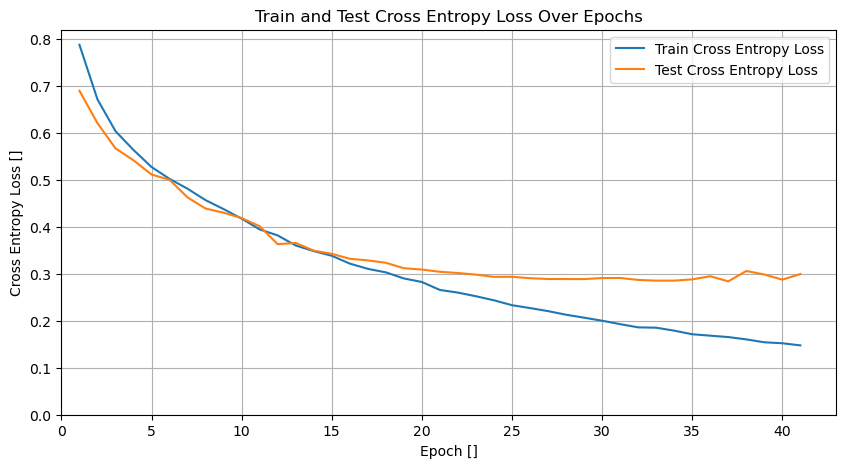

Epoch: 41
---------
Train Loss of [Batch 0/385]: 0.1456
Train Loss of [Batch 100/385]: 0.1357
Train Loss of [Batch 200/385]: 0.1609
Train Loss of [Batch 300/385]: 0.1790

Train loss: 0.14339 | Train accuracy: 96.66%
Train Class-wise Loss: tensor([0.2031, 0.0646], device='cuda:0')

Test loss: 0.30564 | Test accuracy: 94.62%
Test Class-wise Loss: tensor([0.2608, 0.4969], device='cuda:0')



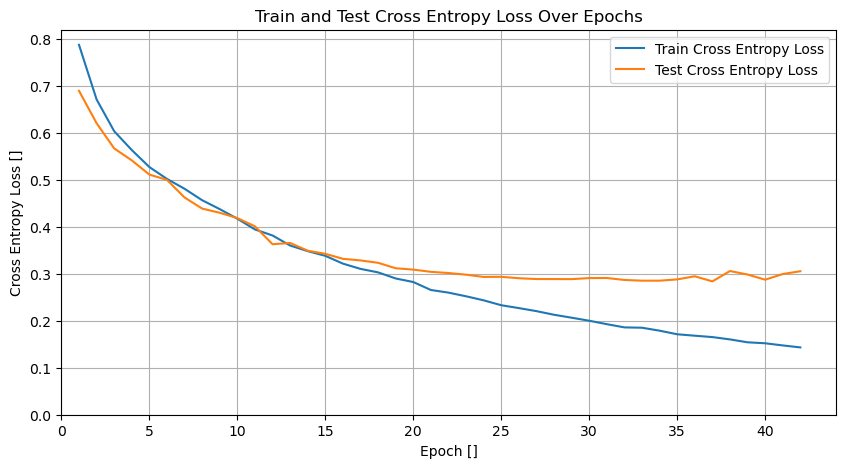

Epoch: 42
---------
Train Loss of [Batch 0/385]: 0.1416
Train Loss of [Batch 100/385]: 0.1163
Train Loss of [Batch 200/385]: 0.1299
Train Loss of [Batch 300/385]: 0.1561

Train loss: 0.14153 | Train accuracy: 96.67%
Train Class-wise Loss: tensor([0.1993, 0.0643], device='cuda:0')

Test loss: 0.30233 | Test accuracy: 94.37%
Test Class-wise Loss: tensor([0.2630, 0.4871], device='cuda:0')



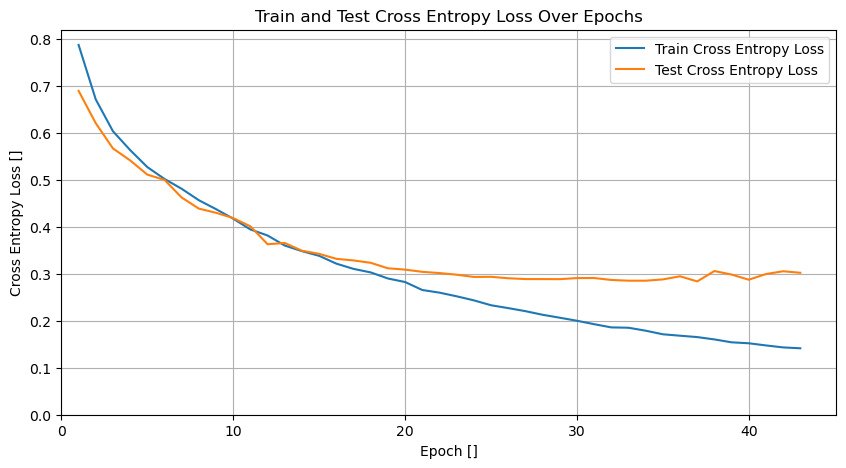

Epoch: 43
---------
Train Loss of [Batch 0/385]: 0.1304
Train Loss of [Batch 100/385]: 0.1307
Train Loss of [Batch 200/385]: 0.1501
Train Loss of [Batch 300/385]: 0.0946

Train loss: 0.13576 | Train accuracy: 96.80%
Train Class-wise Loss: tensor([0.1935, 0.0600], device='cuda:0')

Test loss: 0.31319 | Test accuracy: 94.90%
Test Class-wise Loss: tensor([0.2567, 0.5259], device='cuda:0')



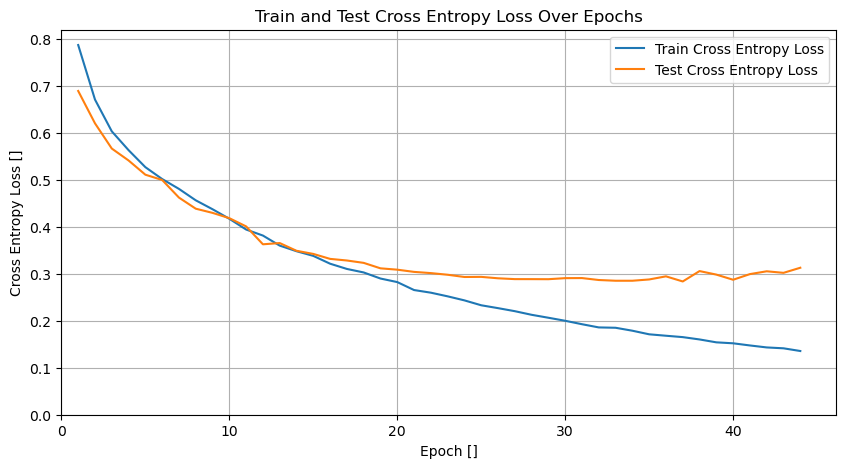

Epoch: 44
---------
Train Loss of [Batch 0/385]: 0.0867
Train Loss of [Batch 100/385]: 0.0930
Train Loss of [Batch 200/385]: 0.1163
Train Loss of [Batch 300/385]: 0.1219

Train loss: 0.13495 | Train accuracy: 96.86%
Train Class-wise Loss: tensor([0.1888, 0.0625], device='cuda:0')

Test loss: 0.31110 | Test accuracy: 94.94%
Test Class-wise Loss: tensor([0.2461, 0.5274], device='cuda:0')



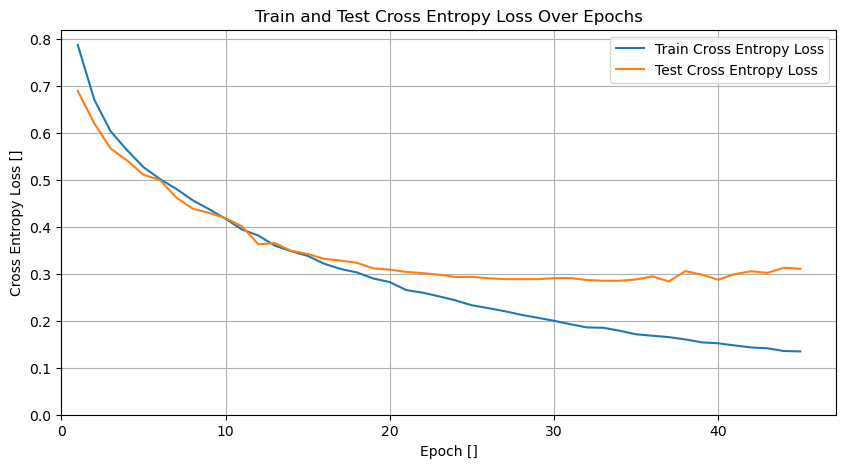

Epoch: 45
---------
Train Loss of [Batch 0/385]: 0.1517
Train Loss of [Batch 100/385]: 0.1167
Train Loss of [Batch 200/385]: 0.1052
Train Loss of [Batch 300/385]: 0.0892

Train loss: 0.13094 | Train accuracy: 96.90%
Train Class-wise Loss: tensor([0.1849, 0.0621], device='cuda:0')

Test loss: 0.32217 | Test accuracy: 95.15%
Test Class-wise Loss: tensor([0.2268, 0.5649], device='cuda:0')



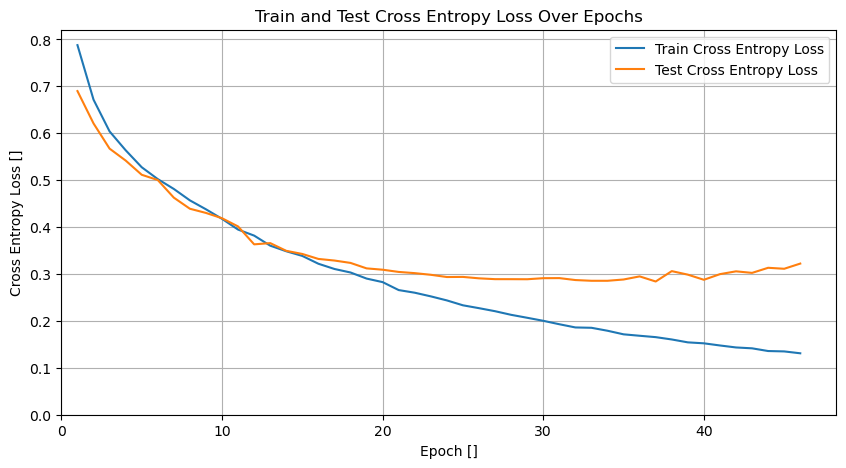

Epoch: 46
---------
Train Loss of [Batch 0/385]: 0.1336
Train Loss of [Batch 100/385]: 0.1506
Train Loss of [Batch 200/385]: 0.1546
Train Loss of [Batch 300/385]: 0.1180

Train loss: 0.12840 | Train accuracy: 96.92%
Train Class-wise Loss: tensor([0.1817, 0.0591], device='cuda:0')

Test loss: 0.30628 | Test accuracy: 94.82%
Test Class-wise Loss: tensor([0.2467, 0.5199], device='cuda:0')



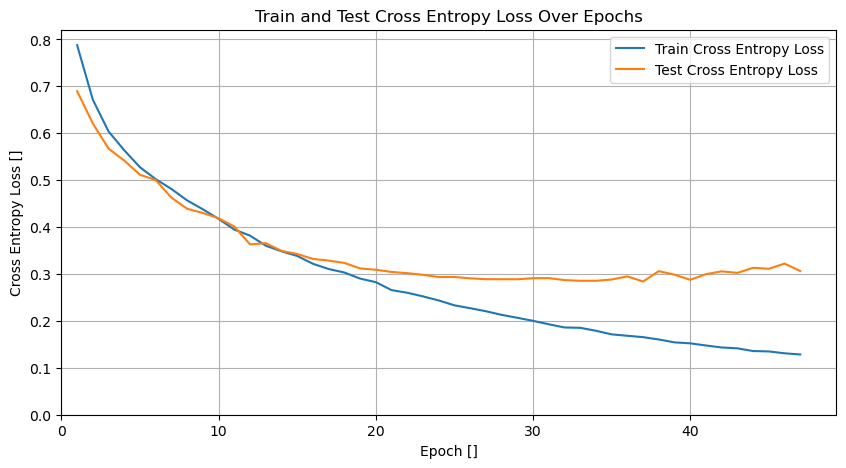

Epoch: 47
---------
Train Loss of [Batch 0/385]: 0.1303
Train Loss of [Batch 100/385]: 0.1085
Train Loss of [Batch 200/385]: 0.0911
Train Loss of [Batch 300/385]: 0.0966

Train loss: 0.12501 | Train accuracy: 97.06%
Train Class-wise Loss: tensor([0.1753, 0.0587], device='cuda:0')

Test loss: 0.33620 | Test accuracy: 95.57%
Test Class-wise Loss: tensor([0.2052, 0.6150], device='cuda:0')



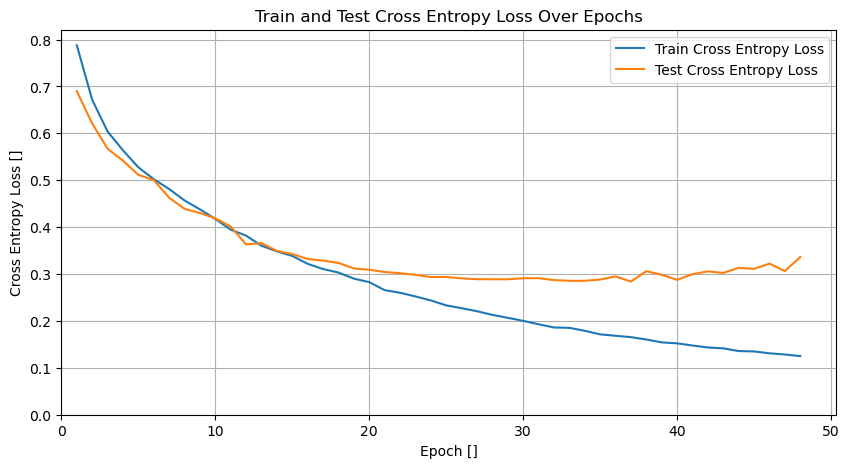

Epoch: 48
---------
Train Loss of [Batch 0/385]: 0.1047
Train Loss of [Batch 100/385]: 0.1207
Train Loss of [Batch 200/385]: 0.1255
Train Loss of [Batch 300/385]: 0.1233

Train loss: 0.12332 | Train accuracy: 97.04%
Train Class-wise Loss: tensor([0.1738, 0.0569], device='cuda:0')

Test loss: 0.31059 | Test accuracy: 94.92%
Test Class-wise Loss: tensor([0.2414, 0.5351], device='cuda:0')



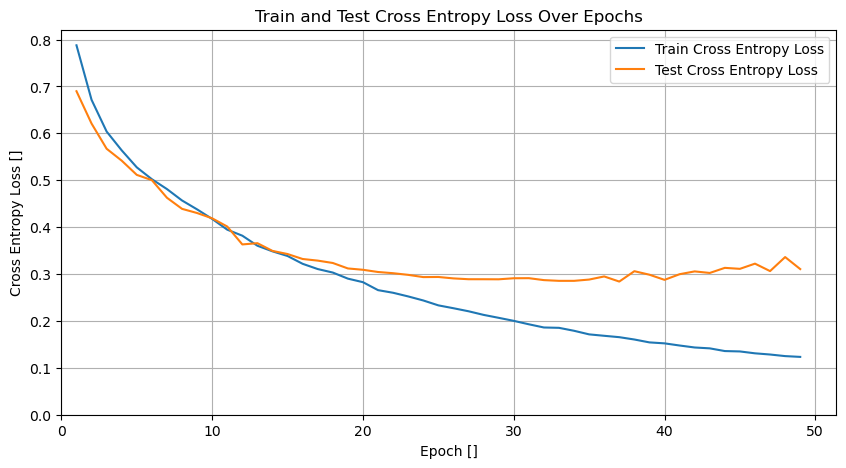

Epoch: 49
---------
Train Loss of [Batch 0/385]: 0.1426
Train Loss of [Batch 100/385]: 0.1102
Train Loss of [Batch 200/385]: 0.1887
Train Loss of [Batch 300/385]: 0.1129

Train loss: 0.12091 | Train accuracy: 97.12%
Train Class-wise Loss: tensor([0.1688, 0.0570], device='cuda:0')

Test loss: 0.32040 | Test accuracy: 95.10%
Test Class-wise Loss: tensor([0.2260, 0.5675], device='cuda:0')



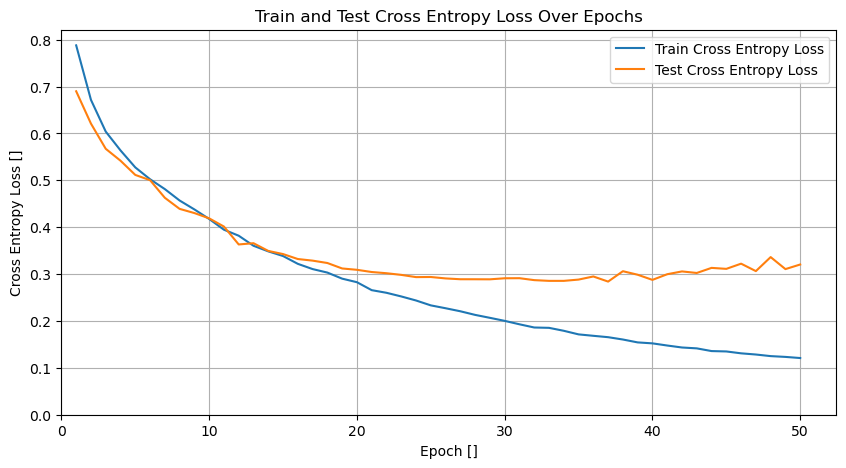

Train time on cuda: 9653.601 seconds


In [41]:
from tqdm.auto import tqdm

# Fix random seed for reproducibility
torch.manual_seed(configs_sc.HYPERPARAMETERS["seed"])
torch.cuda.manual_seed(configs_sc.HYPERPARAMETERS["seed"])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Learning rate:", configs_sc.HYPERPARAMETERS["learning_rate"])
print("Number of epochs:", configs_sc.HYPERPARAMETERS["epochs"])

# measure time with timing function
from timeit import default_timer as timer
start = timer()

# empty lists for storing of evaluation metrics
train_loss_progress = []
test_loss_progress = []
train_class_wise_losses = []
test_class_wise_losses = []

# epoch loop
for epoch in tqdm(range(configs_sc.HYPERPARAMETERS["epochs"])):
    print(f"Epoch: {epoch}\n---------") # print current epoch

    train_loss_epoch, train_class_wise_loss = train_utils.train_step(
        model=model,
        num_classes=configs_sc.HYPERPARAMETERS["num_classes"],
        data_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

    train_loss_progress.append({"epoch": epoch + 1, "train loss": train_loss_epoch})
    train_class_wise_losses.append(train_class_wise_loss.cpu().numpy())  # change to numpy for easier plotting

    test_loss_epoch, test_class_wise_loss = train_utils.test_step(
        model=model,
        num_classes=configs_sc.HYPERPARAMETERS["num_classes"],
        data_loader=test_loader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

    test_loss_progress.append({"epoch": epoch + 1, "test loss": test_loss_epoch})
    test_class_wise_losses.append(test_class_wise_loss.cpu().numpy())


    # Clear output and update plot
    epochs = [entry["epoch"] for entry in train_loss_progress]
    train_losses = [entry["train loss"] for entry in train_loss_progress]
    test_losses = [entry["test loss"].cpu().item() for entry in test_loss_progress]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Train Cross Entropy Loss")
    plt.plot(epochs, test_losses, label="Test Cross Entropy Loss")
    plt.xlabel("Epoch []")
    plt.ylabel("Cross Entropy Loss []")
    plt.title("Train and Test Cross Entropy Loss Over Epochs")
    plt.xlim(left=0) # Force x-axis to start at epoch 0
    plt.ylim(bottom=0) # Force y-axis to start at 0
    plt.legend()
    plt.grid(True)
    plt.show()



end = timer()
train_utils.print_train_time(start, end, device)

**VISUALIZE!**

In [42]:
# Plot train class-wise loss of a specific epoch
# ADJUSTABLE!
# try_epoch = 2
# visualization_utils.plot_classwise_loss(try_epoch, train_class_wise_losses, configs_sc.HYPERPARAMETERS["num_classes"])

In [43]:
# Plot test class-wise loss of a specific epoch
# visualization_utils.plot_classwise_loss(try_epoch, test_class_wise_losses, configs_sc.HYPERPARAMETERS["num_classes"])

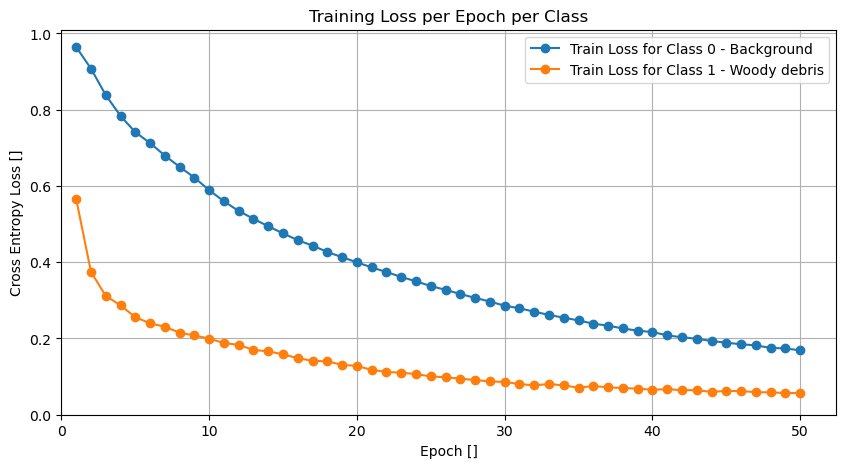

In [44]:
# Plot the train loss curves per class

# Create a list of epoch numbers based on the number of entries in train_class_wise_losses
epochs = list(range(1, len(train_class_wise_losses) + 1))

# Extract the loss for class 0 and class 1 for each epoch.
# Here, we assume that each entry in train_class_wise_losses is a tuple or array like [loss_class0, loss_class1, ...].
class0_losses = [losses[0] for losses in train_class_wise_losses]
class1_losses = [losses[1] for losses in train_class_wise_losses]

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, class0_losses, marker='o', linestyle='-', label="Train Loss for Class 0 - Background")
plt.plot(epochs, class1_losses, marker='o', linestyle='-', label="Train Loss for Class 1 - Woody debris")
plt.xlabel("Epoch []")                          # Set the x-axis label
plt.ylabel("Cross Entropy Loss []")                           # Set the y-axis label
plt.title("Training Loss per Epoch per Class")  # Set the plot title
plt.xlim(left=0)                              # Force x-axis to start at epoch 0
plt.ylim(bottom=0)                            # Force y-axis to start at 0
plt.legend()                                 # Display the legend
plt.grid(True)                               # Enable grid for better readability
plt.show()                                   # Display the plot

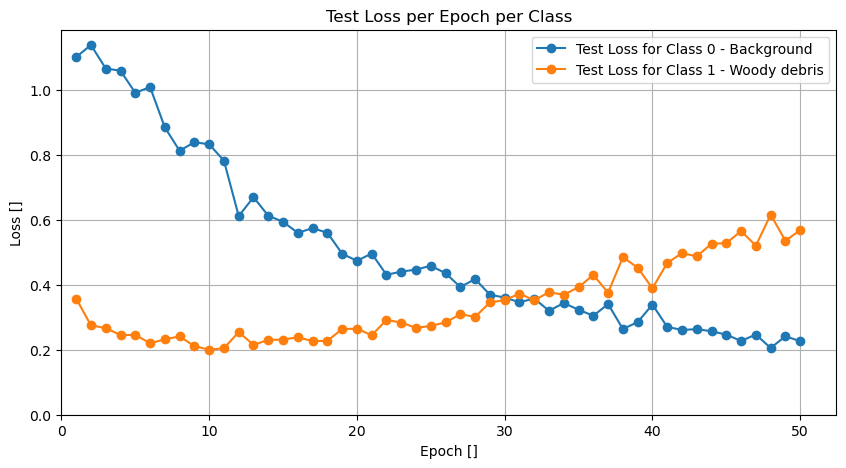

In [45]:
# Plot the test loss curves per class

# Create a list of epoch numbers based on the number of entries in train_class_wise_losses
epochs = list(range(1, len(test_class_wise_losses) + 1))

# Extract the loss for class 0 and class 1 for each epoch.
# Here, we assume that each entry in train_class_wise_losses is a tuple or array like [loss_class0, loss_class1, ...].
class0_losses = [losses[0] for losses in test_class_wise_losses]
class1_losses = [losses[1] for losses in test_class_wise_losses]

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, class0_losses, marker='o', linestyle='-', label="Test Loss for Class 0 - Background")
plt.plot(epochs, class1_losses, marker='o', linestyle='-', label="Test Loss for Class 1 - Woody debris")
plt.xlabel("Epoch []")                          # Set the x-axis label
plt.ylabel("Loss []")                           # Set the y-axis label
plt.title("Test Loss per Epoch per Class")  # Set the plot title
plt.xlim(left=0)                              # Force x-axis to start at epoch 0
plt.ylim(bottom=0)                            # Force y-axis to start at 0
plt.legend()                                 # Display the legend
plt.grid(True)                               # Enable grid for better readability
plt.show()                                   # Display the plot

## 5. Save and load trained model

1. Create individual name of the trained

In [46]:
# Create INDIVIDUAL model name and add to corresponding path

# counter for model version
counter = 1

# function for generating initial model name
def generate_model_name(base_name, epochs, counter):
    return f"{base_name}_{epochs}_{counter}.pth"

base_name = "unet_model_2classes_NOdataaugmentation"

# generate initial name and path
MODEL_NAME = generate_model_name(base_name, configs_sc.HYPERPARAMETERS["epochs"], counter)
save_model_path = os.path.join(saved_model_dir, MODEL_NAME)

# check if there is already a model saved with the same name -> if so: increase the counter
while os.path.exists(save_model_path):
    print(f"Warning: File with name {MODEL_NAME} already exists. Increase the counter...")
    counter += 1
    MODEL_NAME = generate_model_name(base_name, configs_sc.HYPERPARAMETERS["epochs"], counter)
    save_model_path = os.path.join(saved_model_dir, MODEL_NAME)

2. Save the models state dict

In [47]:
# Save the models state dict
print(f"Saving model to: {save_model_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=save_model_path)

Saving model to: /home/sc.uni-leipzig.de/rf37uqip/MoSE/saved_models/unet_model_2classes_NOdataaugmentation_50_1.pth


**3. Load the model**

In [48]:
# Load the model

#######
MODEL_NAME = "unet_model_2classes_NOdataaugmentation_50_1.pth" # ---------> ADJUSTABLE!
#######
save_model_path = os.path.join(saved_model_dir, MODEL_NAME)

# Create a new instance of the model (same class as our saved state_dict())
loaded_model = model_utils.model_0.to(device)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=save_model_path, weights_only=True))

# Send model to GPU
loaded_model = loaded_model.to(device)

## 6. Evaluate trained model

Make predictions for the entire test data set with the trained model and display the results in a confusion matrix.

### 6.1 Confusion Matrix, Accuracies and F1-Scores
Confusion Matrix for entire test data set!

Test accuracy: 95.10%

Test class-wise accuracies: [0.9626921624388682, 0.5103111891028465]



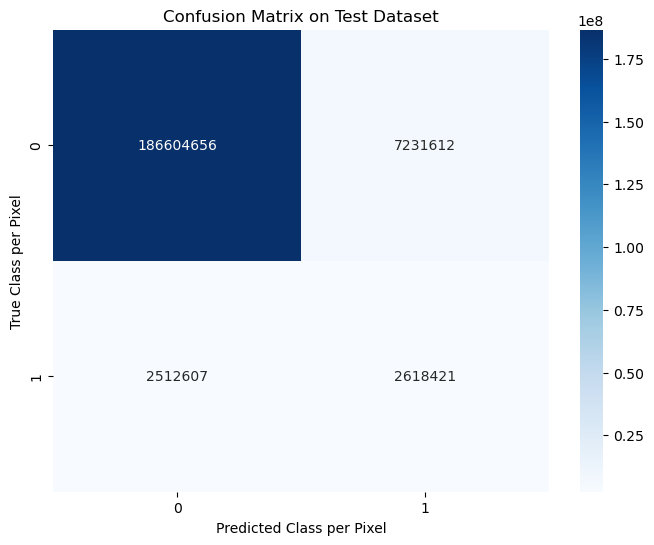

Class-wise evaluation metrics:
   Class  Precision  Recall  F1-Score
0      0     0.9867  0.9627    0.9746
1      1     0.2658  0.5103    0.3496

Macro Precision: 0.6263
Macro Recall: 0.7365
Macro F1-Score: 0.6621


In [49]:
# predictions for entire test data set
evaluation_utils.evaluate_model_with_testdata(loaded_model, test_loader, accuracy_fn, configs_sc.HYPERPARAMETERS["num_classes"], device, F1_analysis = True)

Confusion Matrix, Accuracies and F1-Scores for a part of the test data set!

In [50]:
# predictions for a part of the test data set
# from torch.utils.data import Subset

# # use only __ patch(es) of the test data set
# subset_indices = range(100)  # indices of sample test data set
# subset_test_data = Subset(test_loader.dataset, subset_indices)


# # create subset of test_loader
# subset_test_loader = DataLoader(subset_test_data, batch_size=test_loader.batch_size, shuffle=False)

# evaluation_utils.evaluate_model_with_testdata(
#     loaded_model, subset_test_loader, accuracy_fn, 
#     configs_sc.HYPERPARAMETERS["num_classes"], device, 
#     F1_analysis = True)

### 6.2 Visual Evaluation

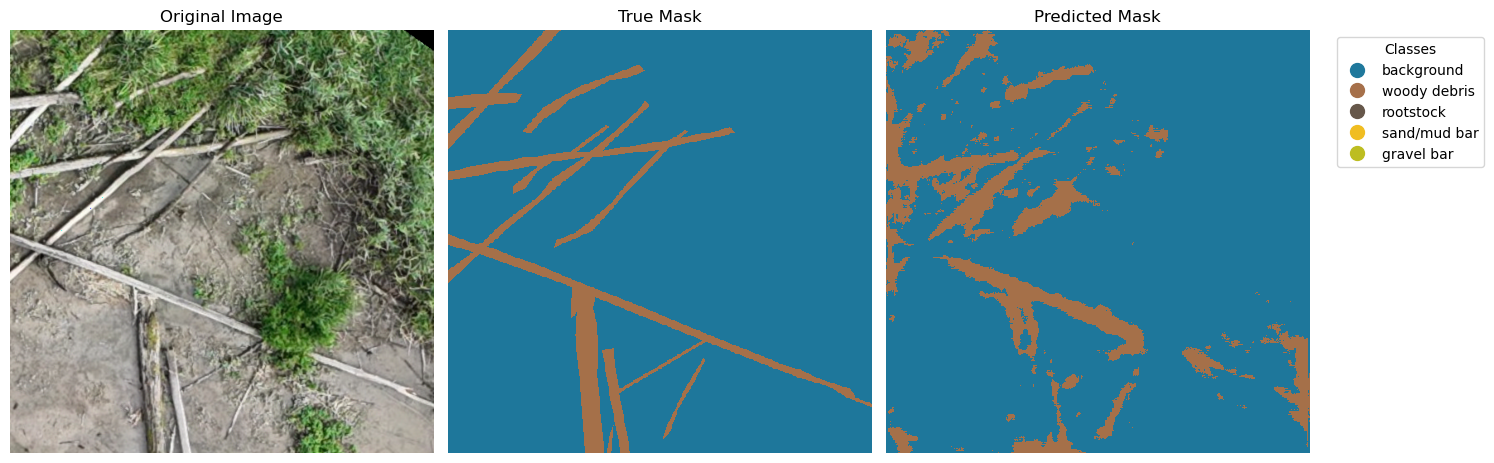

In [51]:
##################### Choose single patch by section and id
SECTION = "A04" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 209 # -------------------->> ADJUSTABLE
#####################
# 1432

# Name of chosen patch
test_patch_name = f"{SECTION}_patch_{TEST_PATCH_ID}.npy"

visualization_utils.visualize_prediction(test_patch_name, test_loader, loaded_model, device, reversed_codes, configs_sc.HYPERPARAMETERS["custom_colors"])

## Citing

In [52]:
# @misc{Iakubovskii:2019,
#   Author = {Pavel Iakubovskii},
#   Title = {Segmentation Models Pytorch},
#   Year = {2019},
#   Publisher = {GitHub},
#   Journal = {GitHub repository},
#   Howpublished = {\url{https://github.com/qubvel/segmentation_models.pytorch}}
# }